In [1]:
#Notebook's settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#from jupyterthemes import jtplot
#jtplot.reset()

# Plotting

import sys
Folder='/Users/egordanilov/Desktop/Lesta_shared/GRF_strong_lensing/jax-strong-lensing/'
sys.path.append(Folder)

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from skimage import measure
#%matplotlib inline


# Basic imports
import numpy as np
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
import math
import time

#JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

from GRF_perturbations.Modules.Data_generation import Observation_conditions_class,generate_data
from GRF_perturbations.Modules.Image_processing import scipy_fit_image,compute_radial_spectrum
from GRF_perturbations.Modules.Jax_Utils import purify_function,jax_map
from GRF_perturbations.Modules.Inference import distribution_Noise_LogSpectrum,compute_SNR_grid,Inference_pipeline,plot_likelihood,infer_LogNorm_params,compute_Loss_grid,Spectra_Loss,compute_Confidence_grid


#Fontsize
FS=18

/usr/local/Caskroom/miniforge/base/envs/env_jax/lib/python3.8/site-packages/jax/_src/lib/__init__.py:31: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


# Observation conditions

In [2]:
pixel_number=100
pixel_scale=0.08

PSF_FWHM=0.1 #arcsec, PSF of HST
exposure_time=2028 #COSMOS exposure
SNR=200 #75th percentile of COSMOS gaussian noise distribution 

Observation_conditions=Observation_conditions_class(pixel_number,pixel_scale,PSF_FWHM,SNR,exposure_time)

get_GRF=Observation_conditions.GRF_getter
simulate_perturbed_image=Observation_conditions.perturbed_image_getter
simulate_unperturbed_image=Observation_conditions.unperturbed_image_getter
simulate_unperturbed_image_pure=lambda kwargs: simulate_unperturbed_image(kwargs,Noise_flag=False)
compute_radial_spectrum_pure=purify_function(compute_radial_spectrum,Observation_conditions.annulus_mask,Observation_conditions.init_freq_index)

noise_var=Observation_conditions.noise_var
parameters=Observation_conditions.parameters
Estimated_Noise_spectral_density=(noise_var*Observation_conditions.annulus_mask).sum()/Observation_conditions.annulus_mask.sum()

# Unperturbed image

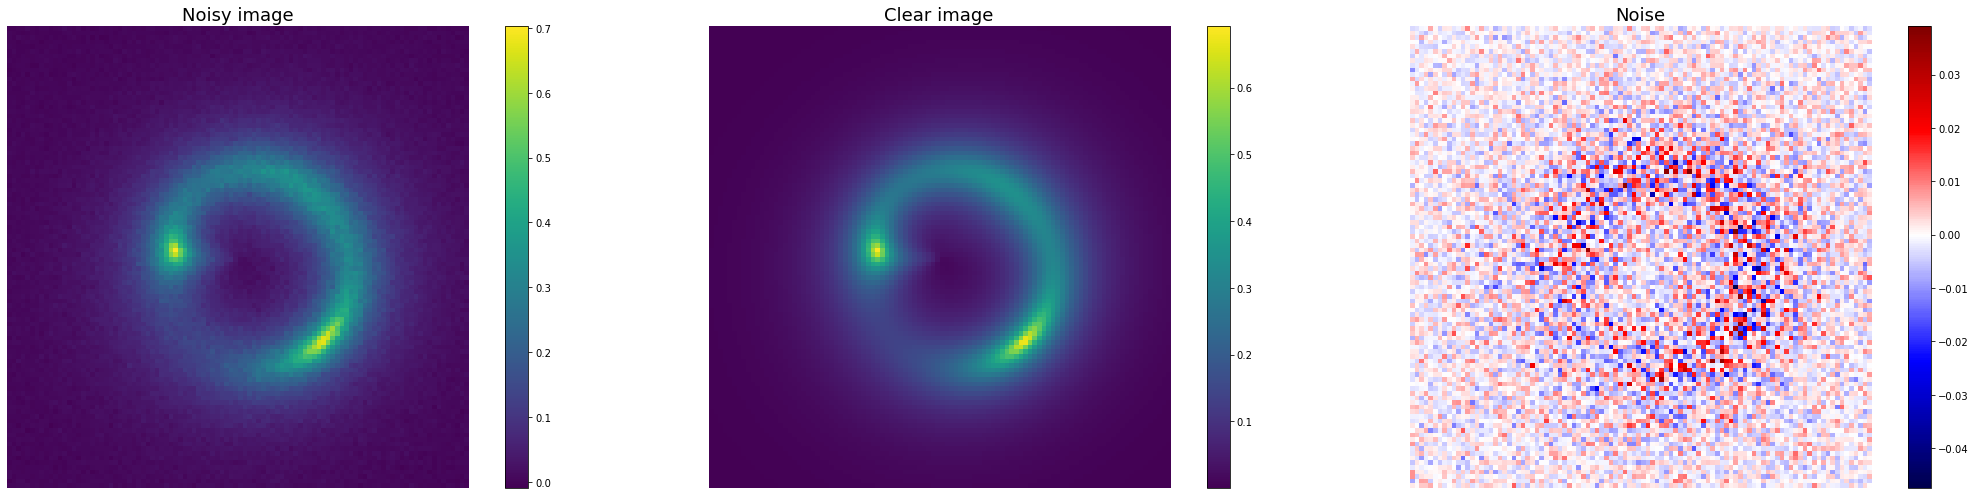

In [3]:
simulate_unperturbed_image=Observation_conditions.unperturbed_image_getter
Image_unperturbed_noiseless=simulate_unperturbed_image(Observation_conditions.kwargs_data,Noise_flag=False)
Image_unperturbed_noisy=simulate_unperturbed_image(Observation_conditions.kwargs_data,Noise_flag=True,noise_seed=42)

fig,ax=plt.subplots(1,3,figsize=(30,7))

img_arr=[]

img_arr+=[ax[0].imshow(Image_unperturbed_noisy)]
img_arr+=[ax[1].imshow(Image_unperturbed_noiseless)]
img_arr+=[ax[2].imshow(Image_unperturbed_noisy-Image_unperturbed_noiseless,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]

titles=['Noisy image','Clear image','Noise']

for i,axis in enumerate(ax):
    axis.set_title(titles[i],fontsize=FS)
    axis.axis('off')
    fig.colorbar(img_arr[i],ax=axis)

plt.tight_layout()
plt.show()

# GRF Spectra grid

In [4]:
logA_center_array=np.linspace(-9,-6.75,96)
Beta_center_array=np.linspace(1,5,96)

logA_step=logA_center_array[1]-logA_center_array[0]
Beta_step=Beta_center_array[1]-Beta_center_array[0]

Beta_min=1-math.floor(1/Beta_step)*Beta_step

Beta_long_array=np.arange(Beta_min,9,step=Beta_step)
Beta_left_array=np.arange(Beta_min,1,step=Beta_step)
Beta_right_array=np.arange(5+Beta_step,9,step=Beta_step)

logA_up_array=np.arange(-6.75+logA_step,-6.75+logA_step*33,step=logA_step)
logA_down_array=np.arange(-9-logA_step*32,-9,step=logA_step)

def load_zipped_tensors(directory,tensor_name,nodes,batches):
    tensor_array=[]
    
    Spectra_grid=[]
    for node in range(nodes):
        Spectra_node_grid=np.load(directory+'{}_node_{}_batch_0.npz'.format(tensor_name,node))['arr_0']
        for batch in range(1,batches):
            next_grid=np.load(directory+'{}_node_{}_batch_{}.npz'.format(tensor_name,node,batch))
            Spectra_node_grid=np.append(Spectra_node_grid,next_grid['arr_0'],axis=0)
            
        if node==0:
            Spectra_grid=Spectra_node_grid
        else:
            Spectra_grid=np.append(Spectra_grid,Spectra_node_grid,axis=1)
        #Spectra_grid_list+=[Spectra_node_grid]
    
    return Spectra_grid

#Central grid
Spectra_central_fine_grid=load_zipped_tensors('data/Spectra_grid_static_noise/Central_grid/','Spectra_grid',16,3)

#Top/bottom grid
Spectra_top_bot_grid=np.load('data/Spectra_grid_static_noise/Top_bottom_grid/Spectra_grid_node_0.npz')
logA_merged_array=np.append(logA_down_array,logA_up_array)

Spectra_top_grid=Spectra_top_bot_grid['arr_0'][32:]
Spectra_bot_grid=Spectra_top_bot_grid['arr_0'][:32]

#Central left/right grid
Spectra_left_right_grid=load_zipped_tensors('data/Spectra_grid_static_noise/Left_Right_grid/','Spectra_grid',1,3)
Spectra_left_grid=Spectra_left_right_grid[:,:len(Beta_left_array)]
Spectra_right_grid=Spectra_left_right_grid[:,len(Beta_left_array):]

#Combined grid
Spectra_central_grid=np.append(Spectra_left_grid,Spectra_central_fine_grid,axis=1)
Spectra_central_grid=np.append(Spectra_central_grid,Spectra_right_grid,axis=1)

Spectra_full_grid=np.append(Spectra_bot_grid,Spectra_central_grid,axis=0)
Spectra_full_grid=np.append(Spectra_full_grid,Spectra_top_grid,axis=0)

logA_full_array=np.append(logA_down_array,logA_center_array)
logA_full_array=np.append(logA_full_array,logA_up_array)

Beta_full_array=np.append(Beta_left_array,Beta_center_array)
Beta_full_array=np.append(Beta_full_array,Beta_right_array)

print('Spectra grid shape', Spectra_full_grid.shape)
print('log(A) array len', len(logA_full_array))
print('Beta array len',len(Beta_full_array))

del Spectra_central_fine_grid; del Spectra_top_bot_grid; del Spectra_top_grid ;del Spectra_bot_grid; del Spectra_left_right_grid; del Spectra_left_grid; del Spectra_right_grid; del Spectra_central_grid
del logA_center_array; del logA_down_array; del logA_merged_array; del logA_up_array; del logA_step
del Beta_center_array; del Beta_left_array; del Beta_long_array; del Beta_right_array; del Beta_min; del Beta_step

Spectra grid shape (160, 214, 100, 46)
log(A) array len 160
Beta array len 214


In [5]:
logA_array=deepcopy(logA_full_array)
Beta_array=deepcopy(Beta_full_array)

Spectra_grid=deepcopy(Spectra_full_grid)

y_labels=np.round(logA_array,2)
x_labels=np.round(Beta_array,2)

num_ticks = 8
# the index of the position of yticks
ticks = np.linspace(0, len(logA_array) - 1, num_ticks, dtype=int)
# the content of labels of these yticks
xticklabels = np.round([x_labels[idx] for idx in ticks],2)
yticklabels = np.round([y_labels[idx] for idx in ticks],2)

def set_labels(im):
    im.set_yticks(ticks)
    im.set_yticklabels(yticklabels)
    im.set_xticks(ticks)
    im.set_xticklabels(xticklabels)

def set_labels_plt(fontsize):
    plt.gca().set_yticklabels(yticklabels,fontsize=fontsize)
    plt.gca().set_xticklabels(xticklabels,fontsize=fontsize)

# Inference prediction grid

In [6]:
SNR_grid=compute_SNR_grid(Spectra_grid,Estimated_Noise_spectral_density)

/Users/egordanilov/Desktop/Lesta_shared/GRF_strong_lensing/jax-strong-lensing/GRF_perturbations/Modules/Inference.py:72: RuntimeWarning: invalid value encountered in log10
  SNR=10*np.log10(np.mean(Spectra_grid-Noise_spectral_density,axis=-1)/Noise_spectral_density)


In [7]:
'''start_time=time.time()



true_logA_index=50
true_Beta_index=100
data_resid_spectrum=Spectra_grid[true_logA_index,true_Beta_index,1]

likelihood,Confidence_grid,pred_logA_index,pred_Beta_index=Inference_pipeline(data_resid_spectrum,Spectra_grid,true_logA_index,true_Beta_index,report_timings=True)

end_time=time.time()

print(end_time-start_time)'''

'start_time=time.time()\n\n\n\ntrue_logA_index=50\ntrue_Beta_index=100\ndata_resid_spectrum=Spectra_grid[true_logA_index,true_Beta_index,1]\n\nlikelihood,Confidence_grid,pred_logA_index,pred_Beta_index=Inference_pipeline(data_resid_spectrum,Spectra_grid,true_logA_index,true_Beta_index,report_timings=True)\n\nend_time=time.time()\n\nprint(end_time-start_time)'

## Prediction bias

In [8]:
def region_borders(Confidence_grid,threshold):
    reg=np.where(Confidence_grid<=threshold)
    
    if len(reg[0])==0:
        return np.array([np.nan,np.nan,np.nan,np.nan])
    
    return np.array([reg[0].min(),reg[0].max(),reg[1].min(),reg[1].max()])

def inference_results(Loss_grid):
    
    
    predicted_indices=np.array(np.unravel_index(np.argmin(Loss_grid),(160,214)))
    
    
    
    #Confidence_grid=compute_Confidence_grid(np.exp(-Loss_grid/2))
    
    
    one_sigma_border_indices=region_borders(Confidence_grid,0.39347)
    two_sigma_border_indices=region_borders(Confidence_grid,0.86466)
    three_sigma_border_indices=region_borders(Confidence_grid,0.988891)
    
    return predicted_indices,one_sigma_border_indices,two_sigma_border_indices,three_sigma_border_indices
    

def inference_over_seeds(Spectra_phase_row,Spectra_grid_shape):
    gamma_data,mu_data,sigma_data=infer_LogNorm_params(Spectra_phase_row)
    def func(data_spec):
        logSpec_data=jnp.log(data_spec)
        Spectra_Loss_pure=lambda model_spectra: Spectra_Loss(model_spectra,logSpec_data,sigma_data)
           
        Loss_grid=compute_Loss_grid(Spectra_grid,Spectra_Loss_pure)
        #results=inference_results(Spectra_grid,Spectra_Loss_pure,Spectra_grid_shape)
        return Loss_grid
    
    return jax_map(func,Spectra_phase_row)

In [9]:
'''start_time=time.time()
q=inference_over_seeds(Spectra_grid[50,50],Spectra_grid.shape)
print(time.time()-start_time)'''

'start_time=time.time()\nq=inference_over_seeds(Spectra_grid[50,50],Spectra_grid.shape)\nprint(time.time()-start_time)'

In [10]:
Coarse_logA_array=logA_array[::11]
Coarse_Beta_array=Beta_array[::11]

In [11]:
'''
Loss_tensor=np.zeros((len(Coarse_logA_array),len(Coarse_Beta_array),100,len(logA_array),len(Beta_array)))
Spectra_grid_shape=Spectra_grid.shape

for i,logA_index in tqdm(enumerate(range(0,len(logA_array),11))):
    
    map_over_beta=lambda Spectra_phase_row: inference_over_seeds(Spectra_phase_row,Spectra_grid_shape)
    Loss_row=jax_map(map_over_beta,Spectra_grid[logA_index,::11])
    Loss_tensor[i]=Loss_row
'''

'\nLoss_tensor=np.zeros((len(Coarse_logA_array),len(Coarse_Beta_array),100,len(logA_array),len(Beta_array)))\nSpectra_grid_shape=Spectra_grid.shape\n\nfor i,logA_index in tqdm(enumerate(range(0,len(logA_array),11))):\n    \n    map_over_beta=lambda Spectra_phase_row: inference_over_seeds(Spectra_phase_row,Spectra_grid_shape)\n    Loss_row=jax_map(map_over_beta,Spectra_grid[logA_index,::11])\n    Loss_tensor[i]=Loss_row\n'

In [140]:
#np.savez('./data/Loss_tensor',Loss_tensor)
Loss_tensor=np.load('./data/Loss_tensor.npz')['arr_0']

In [141]:
Loss_tensor.shape

(15, 20, 100, 160, 214)

In [214]:
def get_cdf(likelihood):
    cdf=np.cumsum(likelihood)
    normalised_cdf=cdf/cdf[-1]
    
    return normalised_cdf

def get_prediction(cdf,pred_index,precentage_covered):
    #indent=np.minimum(0.5,percentage_covered/200.)
    indent=precentage_covered/200.
    
    upper_index=np.where(cdf<=cdf[pred_index]+indent)[0][-1]
    lower_index=np.where(cdf>=cdf[pred_index]-indent)[0][0]
    
    return lower_index,upper_index

def get_conf_intervals(likelihood_grid):
    
    Beta_cdf=get_cdf(likelihood.mean(axis=0))
    Beta_pred_index=np.argmin(np.abs(Beta_cdf-0.5))
    

    logA_cdf=get_cdf(likelihood.mean(axis=1))
    logA_pred_index=np.argmin(np.abs(logA_cdf-0.5))
    
    percentage_covered=[68,95,99.7]
    Beta_conf_regions=np.zeros((3,2))
    logA_conf_regions=np.zeros((3,2))
    
    for i in range(3):
        Beta_conf_regions[i]=get_prediction(Beta_cdf,Beta_pred_index,percentage_covered[i])
        logA_conf_regions[i]=get_prediction(logA_cdf,logA_pred_index,percentage_covered[i])
    
    return logA_pred_index,Beta_pred_index,logA_conf_regions.astype(int),Beta_conf_regions.astype(int)

Text(0.4, 1.0, 'Likelihood')

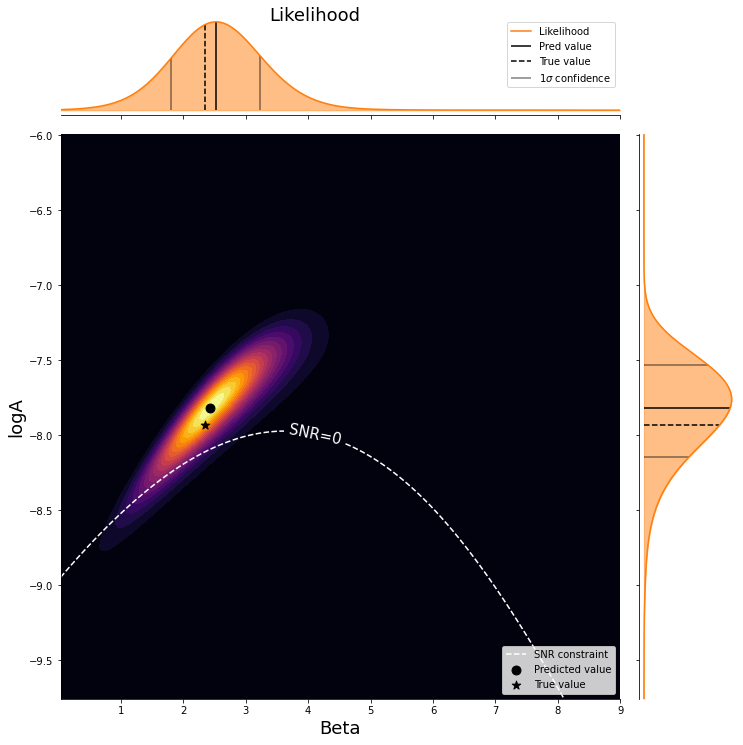

In [423]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage as ndimage
%matplotlib inline


xlim=(1,5)
ylim=(-9,-6.75)

i=7
j=5
phi_ind=2

true_logA_index=np.arange(0,len(logA_array),11)[i]
true_Beta_index=np.arange(0,len(Beta_array),11)[j]

GRF_params=[Coarse_logA_array[i],Coarse_Beta_array[j]]

loss=Loss_tensor[i,j,phi_ind]

pred_logA_index,pred_Beta_index=np.unravel_index(np.argmin(loss),loss.shape)

likelihood=np.exp(-loss/2)
#max_likelihood=(likelihood.max()*2).round(1)/2

#Likelihood

g = sns.JointGrid(height=10)
#levels=np.linspace(0,likelihood.max(),21)

levels=np.linspace(0,(likelihood.max()*10).round()/10,21)
ct=g.ax_joint.contourf(Beta_array,logA_array,likelihood,levels, cmap='inferno')
#ct.collections[0].set_label('Likelihood')

#SNR constraint

img=g.ax_joint.contour(Beta_array,logA_array,SNR_grid,[0],colors='w',linestyles='--')
img.collections[0].set_label('SNR constraint')

fmt = {}
strs = ['SNR=0']
for l,s in zip( img.levels, strs ):
    fmt[l] = s

manual_locations=[(10,4)]
g.ax_joint.clabel(img,[0],inline=1,fontsize=15,fmt=fmt,manual=manual_locations)

#Prediction and truth


g.ax_joint.scatter(Beta_array[pred_Beta_index],logA_array[pred_logA_index],label='Predicted value',marker="o",s=80,color='k')
g.ax_joint.scatter(Beta_array[true_Beta_index],logA_array[true_logA_index],label='True value',marker="*",s=80,color='k')


logA_pred_index,Beta_pred_index,logA_conf_regions,Beta_conf_regions=get_conf_intervals(likelihood)

#Marginalized Beta likelihood

Beta_likelihood=likelihood.mean(axis=0)

likelihood_color='C1'
g.ax_marg_x.plot(Beta_array,Beta_likelihood,color=likelihood_color,label='Likelihood')
g.ax_marg_x.fill_between(Beta_array,0,Beta_likelihood,alpha=0.5,color=likelihood_color)


g.ax_marg_x.vlines(Beta_array[Beta_pred_index],0,Beta_likelihood[Beta_pred_index],color='black',label='Pred value')
g.ax_marg_x.vlines(GRF_params[1],0,likelihood.mean(axis=0)[true_Beta_index],color='k',label='True value',linestyle='--')

for i in range(1):
    g.ax_marg_x.vlines(Beta_array[Beta_conf_regions[i,0]],0,Beta_likelihood[Beta_conf_regions[i,0]],color='black',alpha=0.5,label=r'$1\sigma$'+' confidence')
    g.ax_marg_x.vlines(Beta_array[Beta_conf_regions[i,1]],0,Beta_likelihood[Beta_conf_regions[i,1]],color='black',alpha=0.5)


g.ax_marg_x.legend(loc='upper right')

#Marginalized logA likelihood
logA_likelihood=likelihood.mean(axis=1)

g.ax_marg_y.plot(logA_likelihood,logA_array,color=likelihood_color,label='Likelihood')
g.ax_marg_y.fill_betweenx(logA_array,0,logA_likelihood,alpha=0.5,color=likelihood_color)

g.ax_marg_y.hlines(logA_array[pred_logA_index],0,logA_likelihood[pred_logA_index],color='black',label='Pred value')
g.ax_marg_y.hlines(GRF_params[0],0,logA_likelihood[true_logA_index],color='k',label='True value',linestyle='--')


for i in range(1):
    g.ax_marg_y.hlines(logA_array[logA_conf_regions[i,0]],0,logA_likelihood[logA_conf_regions[i,0]],color='black',alpha=0.5,label=r'$1\sigma$'+' confidence')
    g.ax_marg_y.hlines(logA_array[logA_conf_regions[i,1]],0,logA_likelihood[logA_conf_regions[i,1]],color='black',alpha=0.5)


#Grid labels

g.ax_joint.set_xlabel('Beta',fontsize=FS)
#g.ax_joint.set_xlim(xlim[0],xlim[1])
g.ax_joint.set_ylabel('logA',fontsize=FS)
#g.ax_joint.set_ylim(ylim[0],ylim[1])

g.ax_joint.legend(loc='lower right')
#g.fig.suptitle('Loss='+r'$(\frac{data-model}{\sqrt{\sigma^2_{\sigma^2_{noise}}+\sigma^2_{binning}+\sigma^2_{phase}}})^2$',fontsize=FS,y=1.1)
g.fig.suptitle('Likelihood',fontsize=FS,y=1.,x=0.4)

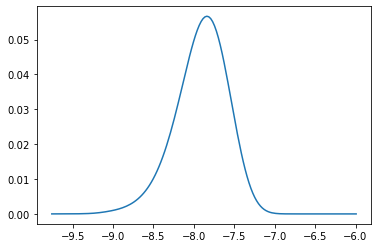

In [247]:
plt.plot(logA_array,likelihood.mean(axis=1))

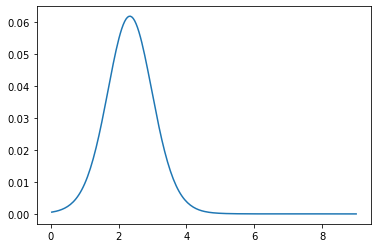

In [248]:
plt.plot(Beta_array,likelihood.mean(axis=0))

In [195]:
logA_pred_index,Beta_pred_index,logA_conf_regions,Beta_conf_regions=get_conf_intervals(likelihood)

In [197]:
print(true_logA_index,true_Beta_index)
print(logA_pred_index,Beta_pred_index)

55 110
35 106


In [198]:
print(logA_conf_regions)

[[ 13.  53.]
 [  2.  65.]
 [  0. 159.]]


In [162]:
get_conf_intervals(logA_array,likelihood.mean(axis=1),center='median',percentage_covered=68.)

(0.5210526315789465, -8.928947368421053, 0.42631578947368354)

In [163]:
get_conf_intervals(Beta_array,likelihood.mean(axis=0),center='median',percentage_covered=68.)

(1.4736842105263164, 4.536842105263158, 1.7684210526315827)

[-8.455263157894738, 4.663157894736842]

In [166]:
cdf=get_cdf(likelihood.mean(axis=0))

In [186]:
pred_Beta_index=np.argmin(np.abs(cdf-0.5))
indent=99.7/200
upper_index=np.where(cdf<=cdf[pred_Beta_index]+indent)[0][-1]
lower_index=np.where(cdf>=cdf[pred_Beta_index]-indent)[0][0]

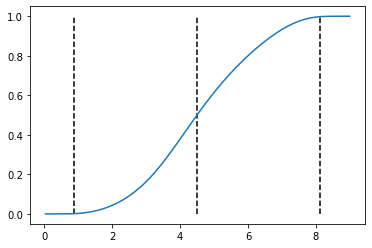

In [187]:
plt.plot(Beta_array,cdf)
plt.vlines(Beta_array[pred_Beta_index],0,1,color='k',linestyle='--')
plt.vlines(Beta_array[upper_index],0,1,color='k',linestyle='--')
plt.vlines(Beta_array[lower_index],0,1,color='k',linestyle='--')

In [170]:
pred_Beta_index=np.argmin(np.abs(cdf-0.5))

In [178]:
upper_index=np.where(cdf<=cdf[pred_Beta_index]+0.34)[0][-1]
lower_index=np.where(cdf>=cdf[pred_Beta_index]-0.34)[0][0]

In [173]:
upper_index

147

In [174]:
pred_Beta_index

106

In [257]:
predicted_indices=np.zeros((Loss_tensor.shape[0],Loss_tensor.shape[1],Loss_tensor.shape[2],2))
logA_confidence_regions=np.zeros((Loss_tensor.shape[0],Loss_tensor.shape[1],Loss_tensor.shape[2],3,2))
Beta_confidence_regions=np.zeros((Loss_tensor.shape[0],Loss_tensor.shape[1],Loss_tensor.shape[2],3,2))



for i,_ in tqdm(enumerate(Coarse_logA_array)):
    for j,_ in enumerate(Coarse_Beta_array):
        for k in range(100):
            
            likelihood=np.exp(-Loss_tensor[i,j,k]/2)
            logA_pred_index,Beta_pred_index,logA_conf_regions,Beta_conf_regions=get_conf_intervals(likelihood)
            
            predicted_indices[i,j,k]=[logA_pred_index,Beta_pred_index]
            logA_confidence_regions[i,j,k]=logA_conf_regions
            Beta_confidence_regions[i,j,k]=logA_conf_regions
            


15it [00:05,  2.54it/s]


In [258]:
'''np.savez('./data/median_predictions',predicted_indices=predicted_indices,\
         logA_confidence_regions=logA_confidence_regions,\
         two_sigma_border_indices=two_sigma_border_indices,
         Beta_confidence_regions=Beta_confidence_regions)'''

In [15]:
'''predictions=np.load('./data/predictions.npz')
predicted_indices=predictions['predicted_indices']
one_sigma_border_indices=predictions['one_sigma_border_indices']
two_sigma_border_indices=predictions['two_sigma_border_indices']
three_sigma_border_indices=predictions['three_sigma_border_indices']'''

In [259]:
predictions=np.load('./data/median_predictions.npz')
predicted_indices=predictions['predicted_indices']
logA_confidence_regions=predictions['logA_confidence_regions']
Beta_confidence_regions=predictions['Beta_confidence_regions']

In [260]:
true_indices=np.array([np.arange(0,len(logA_array),11),np.arange(0,len(Beta_array),11)])

/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_25457/1525615207.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  true_indices=np.array([np.arange(0,len(logA_array),11),np.arange(0,len(Beta_array),11)])


# Perturbation limits

In [17]:
Physical_values_grid=np.load('data/Physical_values_grid/Physical_grid.npz')
GRF_deflections_x=Physical_values_grid['GRF_deflections_x']
GRF_deflections_y=Physical_values_grid['GRF_deflections_y']

total_deflection=np.sqrt(GRF_deflections_x**2+GRF_deflections_y**2)
log_std_deflection=np.log(total_deflection.std(axis=(-2,-1)).mean(axis=-1))

del Physical_values_grid
del GRF_deflections_x; del GRF_deflections_y
del total_deflection

In [32]:
logA_array_Physical=np.linspace(-8.5,-6.,32)
Beta_array_Physical=np.linspace(0,9,32)

indices=measure.find_contours(log_std_deflection,-3)[0]

logA_threshold=indices[:,0]*(logA_array_Physical[1]-logA_array_Physical[0])+logA_array_Physical[0]
Beta_threshold=indices[:,1]*(Beta_array_Physical[1]-Beta_array_Physical[0])+Beta_array_Physical[0]

In [33]:
logA_threshold_indices=(logA_threshold-Coarse_logA_array[0])/(Coarse_logA_array[1]-Coarse_logA_array[0])
Beta_threshold_indices=(Beta_threshold-Coarse_Beta_array[0])/(Coarse_Beta_array[1]-Coarse_Beta_array[0])

In [34]:
from scipy.optimize import curve_fit
sigma=np.ones_like(logA_threshold_indices[-25:])
sigma[-1]=1e-5
popt,_=curve_fit(lambda x,k,b: k*x+b,Beta_threshold_indices[-25:],logA_threshold_indices[-25:],sigma=sigma)

In [35]:
ind_extension=np.array([15,16,17,18])
Beta_threshold_indices=np.append(Beta_threshold_indices,ind_extension)
logA_threshold_indices=np.append(logA_threshold_indices,popt[0]*ind_extension+popt[1])

In [36]:
aligned_Beta_threshold_indices,indices=np.unique(Beta_threshold_indices.round(),return_index=True)
aligned_Beta_threshold_indices=aligned_Beta_threshold_indices.astype(int)
aligned_logA_threshold_indices=logA_threshold_indices[indices].round().astype(int)

In [37]:
Perturbation_matrix=np.ones((len(Coarse_logA_array),len(Coarse_Beta_array)))

for j,logA_threshold_index in enumerate(aligned_logA_threshold_indices):
    Perturbation_matrix[logA_threshold_index+1:,j]=np.nan

Perturbation_matrix[1:,-1]=np.nan

# Median likelihood and 1d contours

## Bias and uncertainty

In [288]:
logA_confidence_regions.shape

(15, 20, 100, 3, 2)

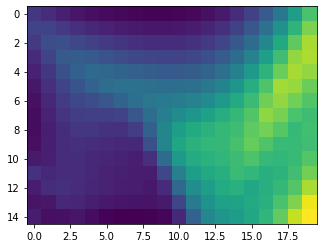

In [393]:
plt.imshow((logA_confidence_regions[:,:,:,0,1]-logA_confidence_regions[:,:,:,0,0]).mean(axis=2))

In [394]:
predicted_bias=np.zeros((15,20,100,2))

uncertainty_width=np.zeros((15,20,100,2,3))


average_prediction=predicted_indices.mean(axis=-2)
for i in range(15):
    for j in range(20):
        
        logA_uncertainty_width=logA_confidence_regions[i,j,:,:,1]-logA_confidence_regions[i,j,:,:,0]
        Beta_uncertainty_width=Beta_confidence_regions[i,j,:,:,1]-Beta_confidence_regions[i,j,:,:,0]
        
        uncertainty_width[i,j,:,0,:]=logA_uncertainty_width
        uncertainty_width[i,j,:,1,:]=Beta_uncertainty_width
        
        predicted_bias[i,j,:,0]=(predicted_indices[i,j,:,0]-true_indices[0][i])
        predicted_bias[i,j,:,1]=(predicted_indices[i,j,:,1]-true_indices[1][j])

## Bias

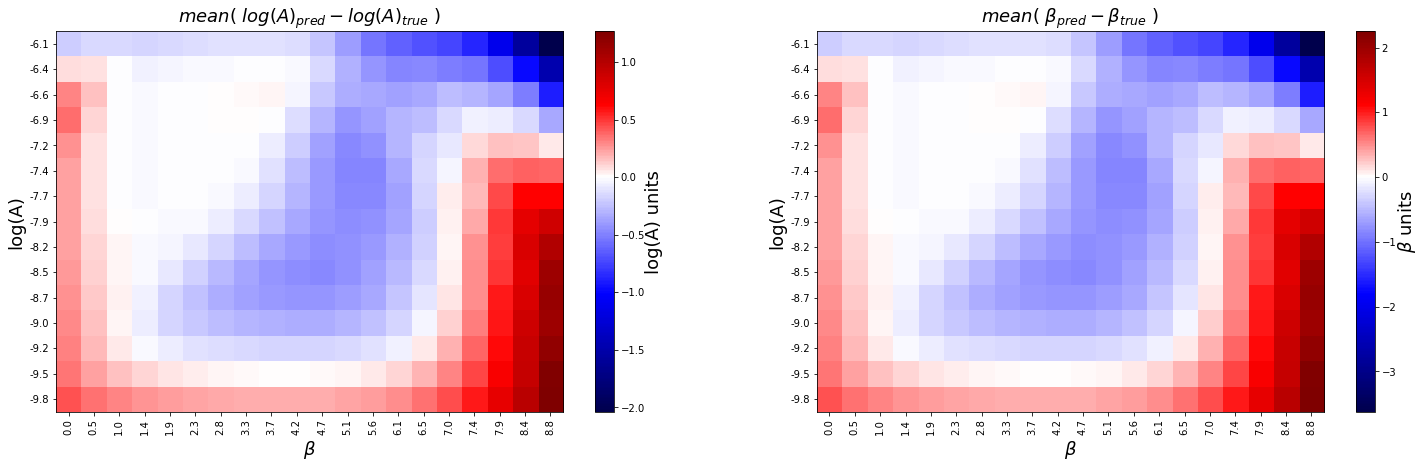

In [395]:
fig,ax=plt.subplots(1,2,figsize=(25,7))

img_arr=[]

mean_bias=predicted_bias.mean(axis=-2)

img_arr+=[ax[0].imshow(mean_bias[:,:,0]*(logA_array[1]-logA_array[0]),cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]
img_arr+=[ax[1].imshow(mean_bias[:,:,0]*(Beta_array[1]-Beta_array[0]),cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]

titles=[r'$mean( \ log(A)_{pred}-log(A)_{true} \ )$',r'$mean( \ \beta_{pred}-\beta_{true} \ )$']
units=['log(A) units',r'$\beta$'+' units']

for i in range(2):
    
    
    ax[i].invert_yaxis()
    ax[i].set_yticks(np.arange(len(Coarse_logA_array)))
    ax[i].set_yticklabels(Coarse_logA_array.round(1))
    
    ax[i].set_xticks(np.arange(len(Coarse_Beta_array)))
    ax[i].set_xticklabels(Coarse_Beta_array.round(1),rotation=90)
    
    ax[i].set_ylabel('log(A)',fontsize=FS)
    ax[i].set_xlabel(r'$\beta$',fontsize=FS)
    ax[i].set_title(titles[i],fontsize=FS)
    
    cbar=plt.colorbar(img_arr[i],ax=ax[i])
    cbar.ax.set_ylabel(units[i],rotation=90,fontsize=FS,labelpad=0)

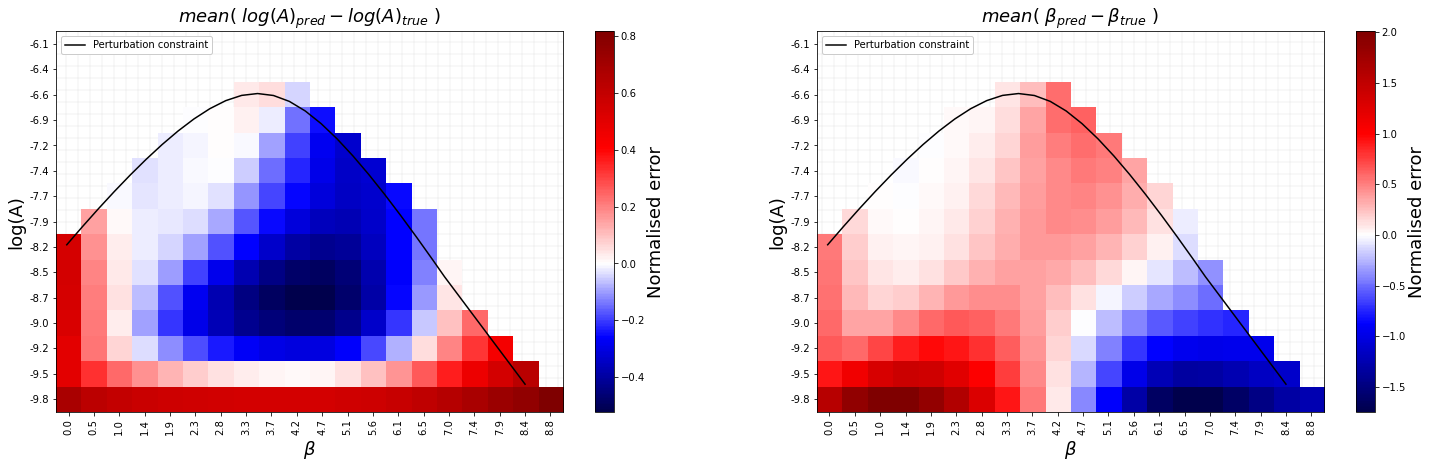

In [407]:
fig,ax=plt.subplots(1,2,figsize=(25,7))

img_arr=[]

mean_bias=(predicted_bias/uncertainty_width[:,:,:,:,0]).mean(axis=-2)


#img_arr+=[ax[0].imshow(mean_bias[:,:,0],cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]
#img_arr+=[ax[1].imshow(mean_bias[:,:,1],cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]

img_arr+=[ax[0].imshow(Perturbation_matrix*mean_bias[:,:,0],cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]
img_arr+=[ax[1].imshow(Perturbation_matrix*mean_bias[:,:,1],cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]

titles=[r'$mean( \ log(A)_{pred}-log(A)_{true} \ )$',r'$mean( \ \beta_{pred}-\beta_{true} \ )$']
units=['Normalised error','Normalised error']

for i in range(2):
    
    
    ax[i].patch.set(hatch="+", edgecolor='black',alpha=0.05)
    
    ax[i].plot(Beta_threshold_indices,logA_threshold_indices,color='k',label='Perturbation constraint')
    ax[i].legend(loc='upper left', framealpha=1)
    
    
    ax[i].invert_yaxis()
    ax[i].set_yticks(np.arange(len(Coarse_logA_array)))
    ax[i].set_yticklabels(Coarse_logA_array.round(1))
    
    ax[i].set_xticks(np.arange(len(Coarse_Beta_array)))
    ax[i].set_xticklabels(Coarse_Beta_array.round(1),rotation=90)
    
    ax[i].set_ylabel('log(A)',fontsize=FS)
    ax[i].set_xlabel(r'$\beta$',fontsize=FS)
    ax[i].set_title(titles[i],fontsize=FS)
    
    cbar=plt.colorbar(img_arr[i],ax=ax[i])
    cbar.ax.set_ylabel(units[i],rotation=90,fontsize=FS,labelpad=2)
    
    texts=[r'${}\sigma$'.format(label.get_text()) for label in cbar.ax.get_yticklabels()]
    
    #cbar_ticklabels=[cbar.ax.get_yticklabels()[i].set_text(texts[i]) for i in range(len(texts))]
    #cbar.ax.set_yticklabels(cbar.ax.get_yticklabels())

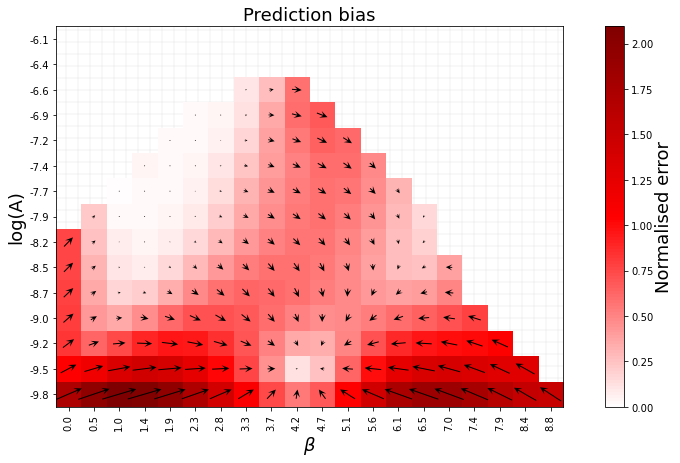

In [412]:
plt.figure(figsize=(15,7))
X,Y=np.meshgrid(Coarse_Beta_array,Coarse_logA_array)
I=mean_bias[:,:,1]*Perturbation_matrix
J=mean_bias[:,:,0]*Perturbation_matrix

img=plt.imshow(np.sqrt(I**2+J**2),cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0),alpha=1)
plt.quiver(I, J,scale=30,width=0.002,headwidth=7,headlength=7.5,pivot='middle')


plt.gca().patch.set(hatch="+", edgecolor='black',alpha=0.05)

plt.gca().invert_yaxis()
plt.yticks(np.arange(len(Coarse_logA_array)),Coarse_logA_array.round(1))
plt.xticks(np.arange(len(Coarse_Beta_array)),Coarse_Beta_array.round(1),rotation=90)

plt.title('Prediction bias',fontsize=FS)
plt.ylabel('log(A)',fontsize=FS)
plt.xlabel(r'$\beta$',fontsize=FS)
cbar=plt.colorbar(img)
cbar.ax.set_ylabel('Normalised error',rotation=90,fontsize=FS,labelpad=2)
plt.show()

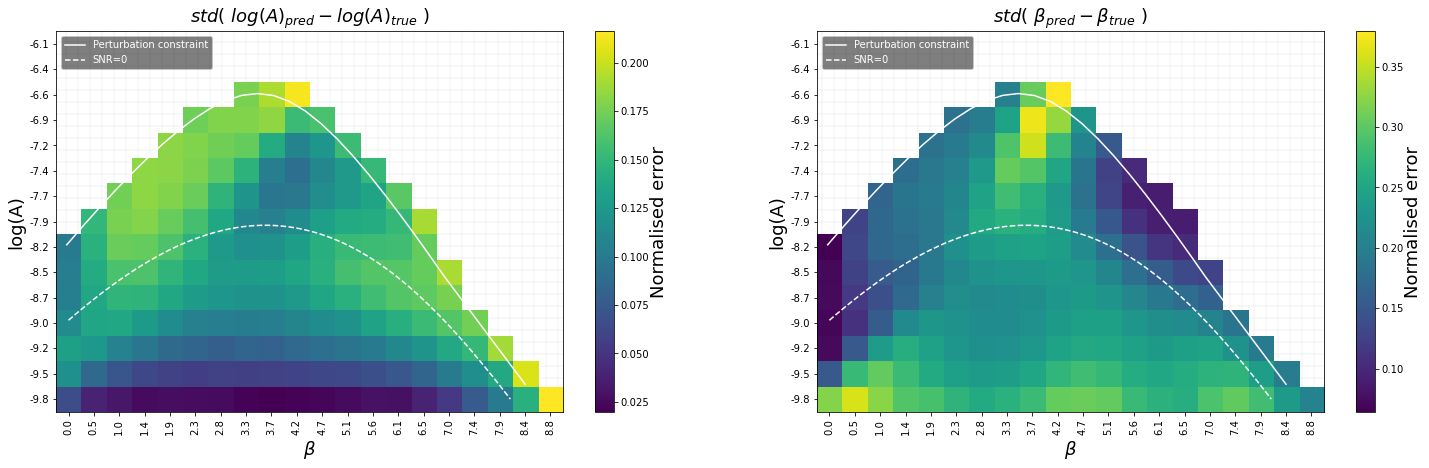

In [408]:
fig,ax=plt.subplots(1,2,figsize=(25,7))

img_arr=[]

std_bias=(predicted_bias/uncertainty_width[:,:,:,:,0]).std(axis=-2)

#img_arr+=[ax[0].imshow(std_bias[:,:,0])]
#img_arr+=[ax[1].imshow(std_bias[:,:,1])]

img_arr+=[ax[0].imshow(Perturbation_matrix*std_bias[:,:,0])]
img_arr+=[ax[1].imshow(Perturbation_matrix*std_bias[:,:,1])]

titles=[r'$std( \ log(A)_{pred}-log(A)_{true} \ )$',r'$std( \ \beta_{pred}-\beta_{true} \ )$']
units=['Normalised error','Normalised error']

for i in range(2):
    
    
    ax[i].patch.set(hatch="+", edgecolor='black',alpha=0.05)
    
    ax[i].plot(Beta_threshold_indices,logA_threshold_indices,color='w',label='Perturbation constraint')
    
    
    imgSNR=ax[i].contour(np.arange(0,len(Beta_array))/11,np.arange(0,len(logA_array))/11,SNR_grid,[0],colors='w',linestyles='--')
    imgSNR.collections[0].set_label('SNR=0')
    l=ax[i].legend(loc='upper left',framealpha=0.5,facecolor='k')
    l.get_texts()[0].set_color('w')
    l.get_texts()[1].set_color('w')
    
    
    ax[i].invert_yaxis()
    ax[i].set_yticks(np.arange(len(Coarse_logA_array)))
    ax[i].set_yticklabels(Coarse_logA_array.round(1))
    
    ax[i].set_xticks(np.arange(len(Coarse_Beta_array)))
    ax[i].set_xticklabels(Coarse_Beta_array.round(1),rotation=90)
    
    ax[i].set_ylabel('log(A)',fontsize=FS)
    ax[i].set_xlabel(r'$\beta$',fontsize=FS)
    ax[i].set_title(titles[i],fontsize=FS)
    
    cbar=plt.colorbar(img_arr[i],ax=ax[i])
    cbar.ax.set_ylabel(units[i],rotation=90,fontsize=FS,labelpad=0)

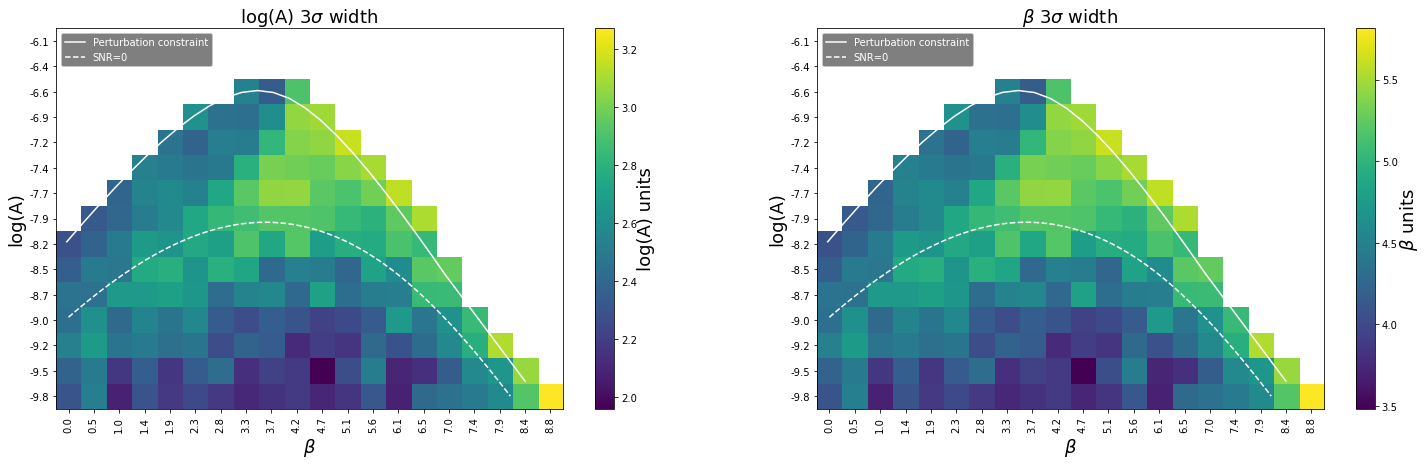

In [417]:
fig,ax=plt.subplots(1,2,figsize=(25,7))

img_arr=[]

sigma=3
mean_uncert=uncertainty_width.mean(axis=2)



img_arr+=[ax[0].imshow(Perturbation_matrix*mean_uncert[:,:,0,sigma-1]*(logA_array[1]-logA_array[0]))]
img_arr+=[ax[1].imshow(Perturbation_matrix*mean_uncert[:,:,1,sigma-1]*(Beta_array[1]-Beta_array[0]))]


titles=['log(A) '+str(sigma)+r'$\sigma$'+' width',r'$\beta$ '+str(sigma)+r'$\sigma$'+' width']
units=['log(A) units',r'$\beta$'+' units']

for i in range(2):
    
    
    ax[i].plot(Beta_threshold_indices,logA_threshold_indices,color='w',label='Perturbation constraint')
    
    
    imgSNR=ax[i].contour(np.arange(0,len(Beta_array))/11,np.arange(0,len(logA_array))/11,SNR_grid,[0],colors='w',linestyles='--')
    imgSNR.collections[0].set_label('SNR=0')
    l=ax[i].legend(loc='upper left',framealpha=0.5,facecolor='k')
    l.get_texts()[0].set_color('w')
    l.get_texts()[1].set_color('w')
    
    ax[i].invert_yaxis()
    ax[i].set_yticks(np.arange(len(Coarse_logA_array)))
    ax[i].set_yticklabels(Coarse_logA_array.round(1))
    
    ax[i].set_xticks(np.arange(len(Coarse_Beta_array)))
    ax[i].set_xticklabels(Coarse_Beta_array.round(1),rotation=90)
    
    ax[i].set_ylabel('log(A)',fontsize=FS)
    ax[i].set_xlabel(r'$\beta$',fontsize=FS)
    ax[i].set_title(titles[i],fontsize=FS)
    
    cbar=plt.colorbar(img_arr[i],ax=ax[i])
    cbar.ax.set_ylabel(units[i],rotation=90,fontsize=FS,labelpad=0)

In [371]:
uncertainty_width.shape

(15, 20, 100, 2, 3)

## Prediction bias

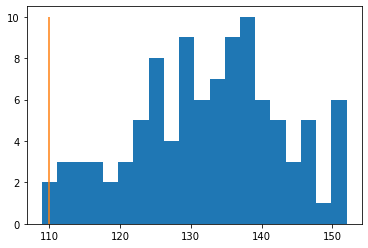

In [286]:
i=7
j=10
q=plt.hist(predicted_indices[i,j,:,1],bins=20)
plt.vlines(true_indices[1][j],0,q[0].max(),color='C1')

In [264]:
predicted_bias=np.zeros((15,20,2))
predicted_bias_std=np.zeros((15,20,2))


average_prediction=predicted_indices.mean(axis=-2)
for i in range(15):
    for j in range(20):
        
        predicted_bias[i,j,0]=(predicted_indices[i,j,:,0]-true_indices[0][i]).mean()
        predicted_bias[i,j,1]=(predicted_indices[i,j,:,1]-true_indices[1][j]).mean()
        
        
        predicted_bias_std[i,j,0]=(predicted_indices[i,j,:,0]-true_indices[0][i]).std()
        predicted_bias_std[i,j,1]=(predicted_indices[i,j,:,1]-true_indices[1][j]).std()

TypeError: Invalid shape (15, 20, 2) for image data

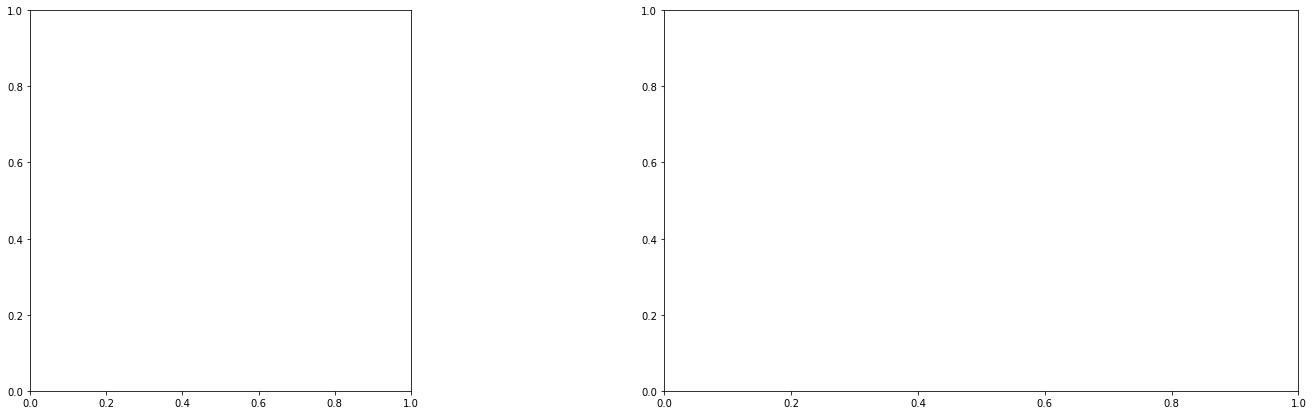

In [365]:
fig,ax=plt.subplots(1,2,figsize=(25,7))

img_arr=[]



img_arr+=[ax[0].imshow(predicted_bias[:,:,0]*(logA_array[1]-logA_array[0]),cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]
img_arr+=[ax[1].imshow(predicted_bias[:,:,1]*(Beta_array[1]-Beta_array[0]),cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]

titles=[r'$mean( \ log(A)_{pred}-log(A)_{true} \ )$',r'$mean( \ \beta_{pred}-\beta_{true} \ )$']
units=['log(A) units',r'$\beta$'+' units']

for i in range(2):
    
    
    
    ax[i].invert_yaxis()
    ax[i].set_yticks(np.arange(len(Coarse_logA_array)))
    ax[i].set_yticklabels(Coarse_logA_array.round(1))
    
    ax[i].set_xticks(np.arange(len(Coarse_Beta_array)))
    ax[i].set_xticklabels(Coarse_Beta_array.round(1),rotation=90)
    
    ax[i].set_ylabel('log(A)',fontsize=FS)
    ax[i].set_xlabel(r'$\beta$',fontsize=FS)
    ax[i].set_title(titles[i],fontsize=FS)
    
    cbar=plt.colorbar(img_arr[i],ax=ax[i])
    cbar.ax.set_ylabel(units[i],rotation=90,fontsize=FS,labelpad=0)

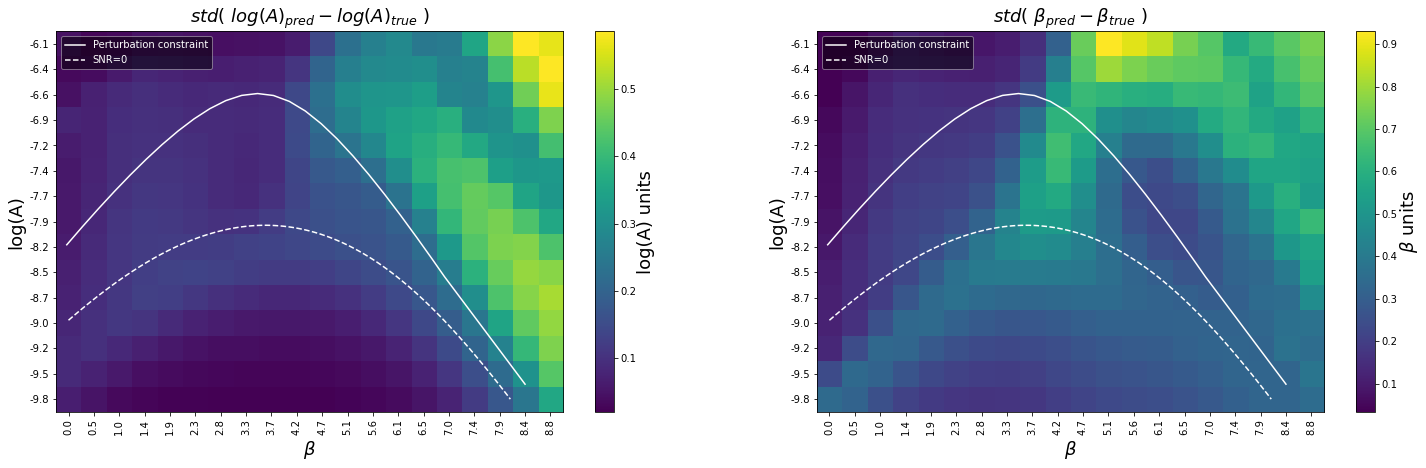

In [266]:
fig,ax=plt.subplots(1,2,figsize=(25,7))

img_arr=[]



img_arr+=[ax[0].imshow(predicted_bias_std[:,:,0]*(logA_array[1]-logA_array[0]))]
img_arr+=[ax[1].imshow(predicted_bias_std[:,:,1]*(Beta_array[1]-Beta_array[0]))]

titles=[r'$std( \ log(A)_{pred}-log(A)_{true} \ )$',r'$std( \ \beta_{pred}-\beta_{true} \ )$']
units=['log(A) units',r'$\beta$'+' units']

for i in range(2):
    
    ax[i].patch.set(hatch="+", edgecolor='black',alpha=0.05)
    
    ax[i].plot(Beta_threshold_indices,logA_threshold_indices,color='w',label='Perturbation constraint')
    
    
    imgSNR=ax[i].contour(np.arange(0,len(Beta_array))/11,np.arange(0,len(logA_array))/11,SNR_grid,[0],colors='w',linestyles='--')
    imgSNR.collections[0].set_label('SNR=0')
    l=ax[i].legend(loc='upper left',framealpha=0.5,facecolor='k')
    l.get_texts()[0].set_color('w')
    l.get_texts()[1].set_color('w')
    
    ax[i].invert_yaxis()
    ax[i].set_yticks(np.arange(len(Coarse_logA_array)))
    ax[i].set_yticklabels(Coarse_logA_array.round(1))
    
    ax[i].set_xticks(np.arange(len(Coarse_Beta_array)))
    ax[i].set_xticklabels(Coarse_Beta_array.round(1),rotation=90)
    
    ax[i].set_ylabel('log(A)',fontsize=FS)
    ax[i].set_xlabel(r'$\beta$',fontsize=FS)
    ax[i].set_title(titles[i],fontsize=FS)
    
    cbar=plt.colorbar(img_arr[i],ax=ax[i])
    cbar.ax.set_ylabel(units[i],rotation=90,fontsize=FS,labelpad=0)

# Max loglikelihood and 2d contours

#  Prediction bias

In [24]:
predicted_bias=np.zeros((15,20,2))
predicted_bias_std=np.zeros((15,20,2))
rel_error=np.zeros((15,20,2))
abs_error=np.zeros((15,20,2))


average_prediction=predicted_indices.mean(axis=-2)
for i in range(15):
    for j in range(20):
        
        pred_logA=logA_array[predicted_indices[i,j,:,0].astype(int)]
        true_logA=logA_array[true_indices[0][i]]
        
        delta_A=np.power(10,pred_logA)-np.power(10,true_logA)
        abs_error[i,j,0]=delta_A.mean()/np.power(10,true_logA)
        
        rel_error[i,j,0]=(predicted_indices[i,j,:,0]-true_indices[0][i]).mean()*(logA_array[1]-logA_array[0])/np.abs(logA_array[true_indices[0][i]])
        rel_error[i,j,1]=(predicted_indices[i,j,:,1]-true_indices[1][i]).mean()*(Beta_array[1]-Beta_array[0])/Beta_array[true_indices[1][j]]
        
        predicted_bias[i,j,0]=(predicted_indices[i,j,:,0]-true_indices[0][i]).mean()
        predicted_bias[i,j,1]=(predicted_indices[i,j,:,1]-true_indices[1][j]).mean()
        
        
        predicted_bias_std[i,j,0]=(predicted_indices[i,j,:,0]-true_indices[0][i]).std()
        predicted_bias_std[i,j,1]=(predicted_indices[i,j,:,1]-true_indices[1][j]).std()

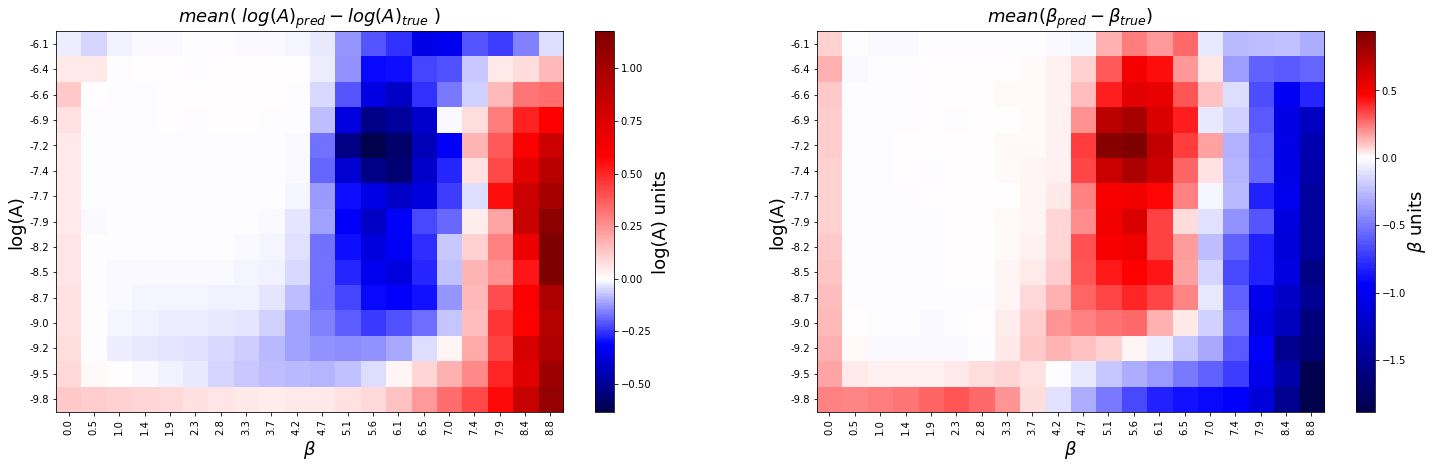

In [29]:
fig,ax=plt.subplots(1,2,figsize=(25,7))

img_arr=[]



img_arr+=[ax[0].imshow(predicted_bias[:,:,0]*(logA_array[1]-logA_array[0]),cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]
img_arr+=[ax[1].imshow(predicted_bias[:,:,1]*(Beta_array[1]-Beta_array[0]),cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]

titles=[r'$mean( \ log(A)_{pred}-log(A)_{true} \ )$',r'$mean( \ \beta_{pred}-\beta_{true} \ )$']
units=['log(A) units',r'$\beta$'+' units']

for i in range(2):
    
    #ax[i].contourf(Beta_threshold_indices,logA_threshold_indices,color='k',label='Perturbation constraint')
    #ax[i].plot(Beta_threshold_indices,logA_threshold_indices,color='k',label='Perturbation constraint')
    #ax[i].legend(framealpha=1)
    
    ax[i].invert_yaxis()
    ax[i].set_yticks(np.arange(len(Coarse_logA_array)))
    ax[i].set_yticklabels(Coarse_logA_array.round(1))
    
    ax[i].set_xticks(np.arange(len(Coarse_Beta_array)))
    ax[i].set_xticklabels(Coarse_Beta_array.round(1),rotation=90)
    
    ax[i].set_ylabel('log(A)',fontsize=FS)
    ax[i].set_xlabel(r'$\beta$',fontsize=FS)
    ax[i].set_title(titles[i],fontsize=FS)
    
    cbar=plt.colorbar(img_arr[i],ax=ax[i])
    cbar.ax.set_ylabel(units[i],rotation=90,fontsize=FS,labelpad=0)

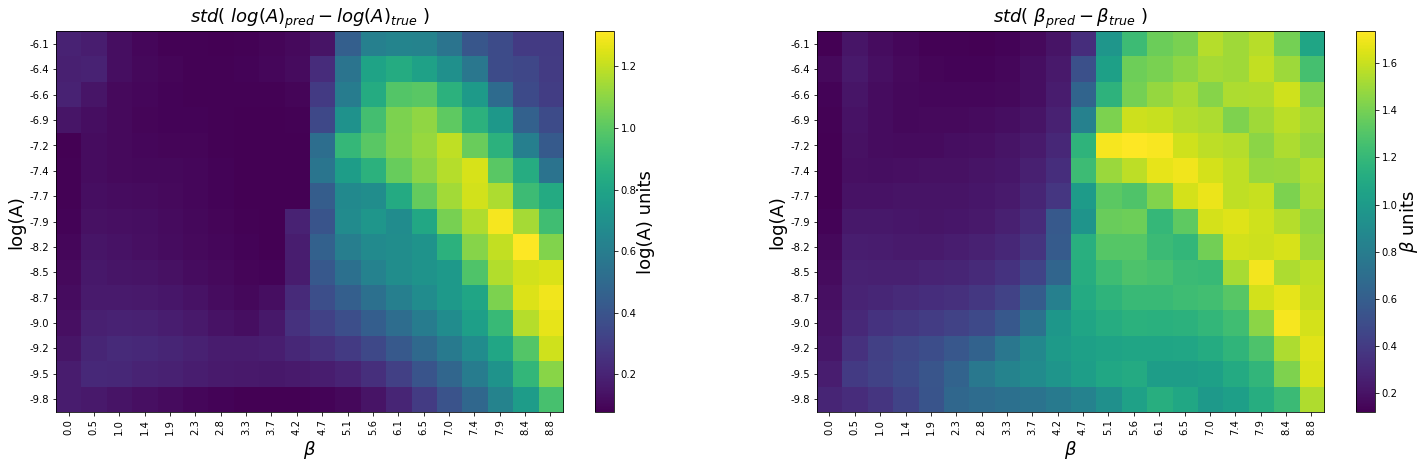

In [30]:
fig,ax=plt.subplots(1,2,figsize=(25,7))

img_arr=[]



img_arr+=[ax[0].imshow(predicted_bias_std[:,:,0]*(logA_array[1]-logA_array[0]))]
img_arr+=[ax[1].imshow(predicted_bias_std[:,:,1]*(Beta_array[1]-Beta_array[0]))]

titles=[r'$std( \ log(A)_{pred}-log(A)_{true} \ )$',r'$std( \ \beta_{pred}-\beta_{true} \ )$']
units=['log(A) units',r'$\beta$'+' units']

for i in range(2):
    
    #ax[i].contourf(Beta_threshold_indices,logA_threshold_indices,color='k',label='Perturbation constraint')
    #ax[i].plot(Beta_threshold_indices,logA_threshold_indices,color='k',label='Perturbation constraint')
    #ax[i].legend(framealpha=1)
    
    ax[i].invert_yaxis()
    ax[i].set_yticks(np.arange(len(Coarse_logA_array)))
    ax[i].set_yticklabels(Coarse_logA_array.round(1))
    
    ax[i].set_xticks(np.arange(len(Coarse_Beta_array)))
    ax[i].set_xticklabels(Coarse_Beta_array.round(1),rotation=90)
    
    ax[i].set_ylabel('log(A)',fontsize=FS)
    ax[i].set_xlabel(r'$\beta$',fontsize=FS)
    ax[i].set_title(titles[i],fontsize=FS)
    
    cbar=plt.colorbar(img_arr[i],ax=ax[i])
    cbar.ax.set_ylabel(units[i],rotation=90,fontsize=FS,labelpad=0)

In [178]:
i,j=np.unravel_index(np.argmin(predicted_bias[:,:,0]),predicted_bias[:,:,0].shape)

GRF_potential,data_image,fit_image,data_resid_spectrum=generate_data([Coarse_logA_array[i],Coarse_Beta_array[j]],1,Observation_conditions)

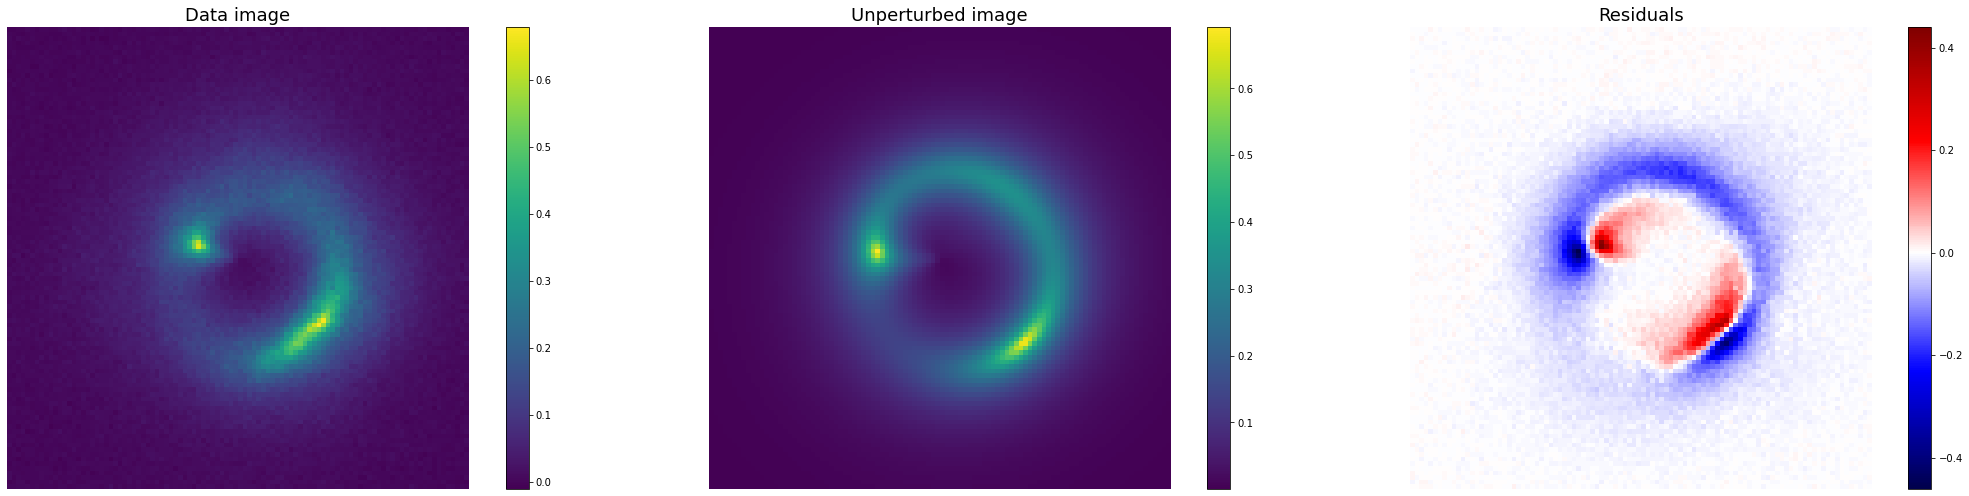

In [183]:
fig,ax=plt.subplots(1,3,figsize=(30,7))

img_arr=[]

img_arr+=[ax[0].imshow(data_image)]
img_arr+=[ax[1].imshow(Image_unperturbed_noiseless)]
img_arr+=[ax[2].imshow(data_image-Image_unperturbed_noiseless,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]

titles=['Data image','Unperturbed image','Residuals']

for i,axis in enumerate(ax):
    axis.set_title(titles[i],fontsize=FS)
    axis.axis('off')
    fig.colorbar(img_arr[i],ax=axis)

plt.tight_layout()
plt.show()

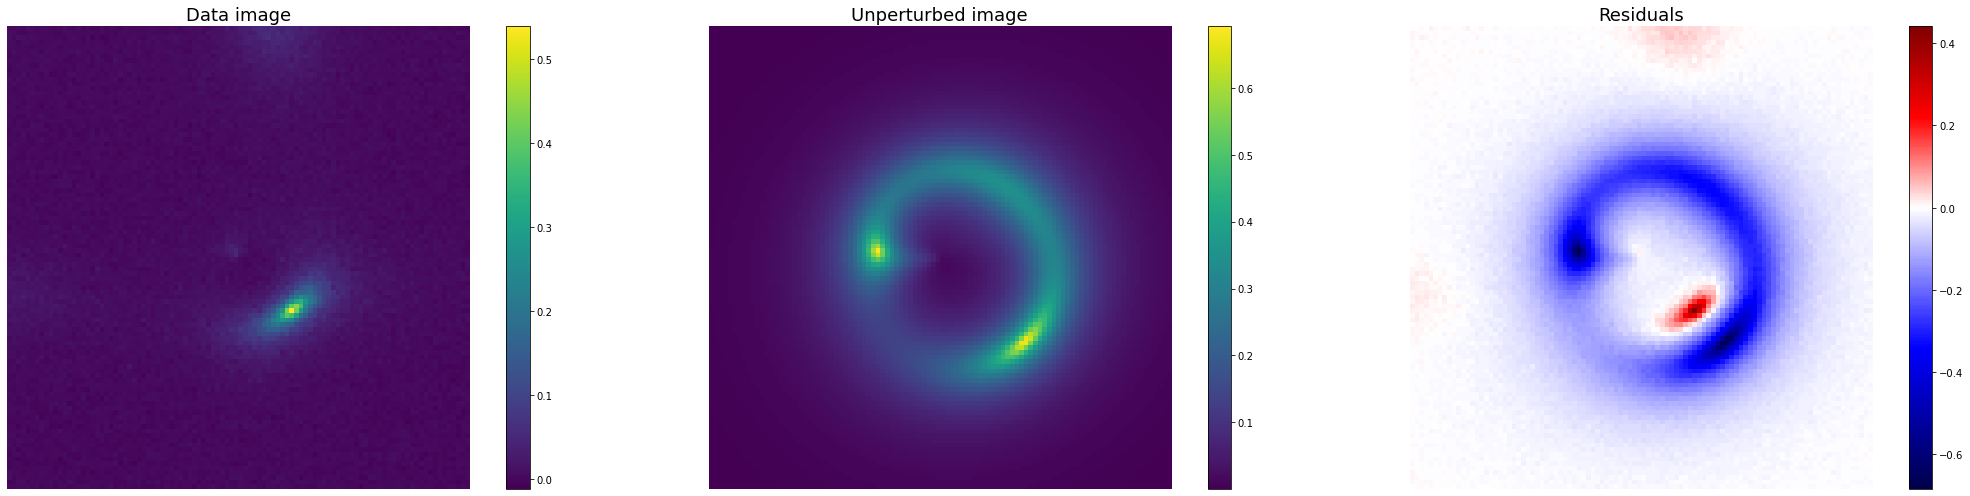

In [185]:
i,j=np.unravel_index(np.argmax(predicted_bias[:,:,0]),predicted_bias[:,:,0].shape)

GRF_potential,data_image,fit_image,data_resid_spectrum=generate_data([Coarse_logA_array[i],Coarse_Beta_array[j]],1,Observation_conditions)

fig,ax=plt.subplots(1,3,figsize=(30,7))

img_arr=[]

img_arr+=[ax[0].imshow(data_image)]
img_arr+=[ax[1].imshow(Image_unperturbed_noiseless)]
img_arr+=[ax[2].imshow(data_image-Image_unperturbed_noiseless,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]

titles=['Data image','Unperturbed image','Residuals']

for i,axis in enumerate(ax):
    axis.set_title(titles[i],fontsize=FS)
    axis.axis('off')
    fig.colorbar(img_arr[i],ax=axis)

plt.tight_layout()
plt.show()

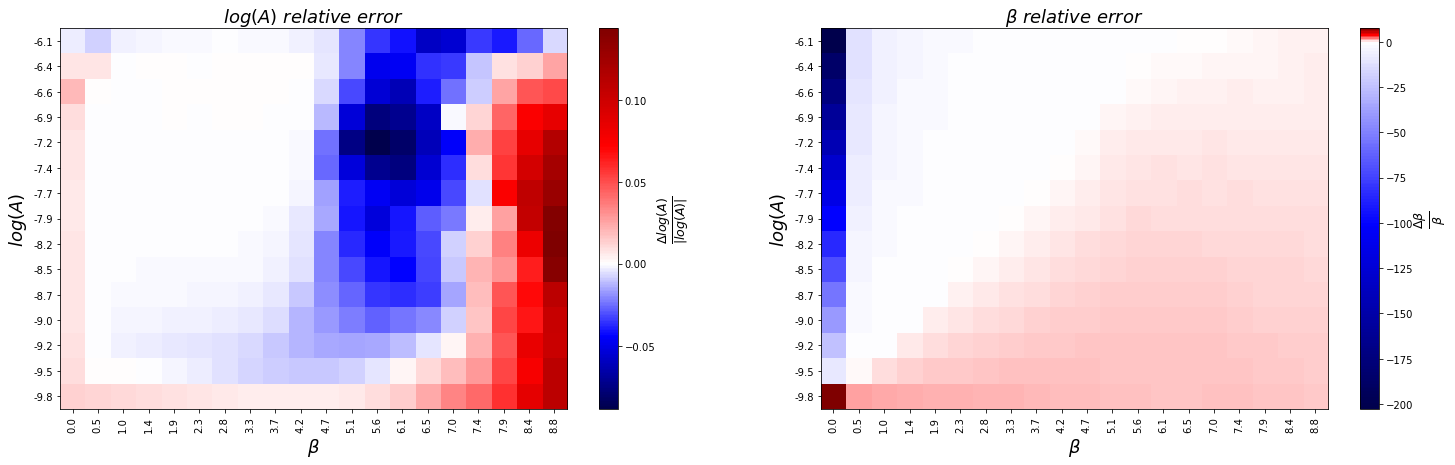

In [147]:
fig,ax=plt.subplots(1,2,figsize=(25,7))

img_arr=[]

img_arr+=[ax[0].imshow(rel_error[:,:,0],cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]
img_arr+=[ax[1].imshow(rel_error[:,:,1],cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]

titles=[r'$log(A) \ relative \ error $',r'$\beta \ relative \ error $']
units=[r'$\frac{\Delta log(A)}{|log(A)|}$',r'$\frac{\Delta \beta}{\beta}$']

for i in range(2):
    ax[i].invert_yaxis()
    ax[i].set_yticks(np.arange(len(Coarse_logA_array)))
    ax[i].set_yticklabels(Coarse_logA_array.round(1))
    
    ax[i].set_xticks(np.arange(len(Coarse_Beta_array)))
    ax[i].set_xticklabels(Coarse_Beta_array.round(1),rotation=90)
    
    ax[i].set_ylabel(r'$log(A)$',fontsize=FS)
    ax[i].set_xlabel(r'$\beta$',fontsize=FS)
    ax[i].set_title(titles[i],fontsize=FS)
    
    cbar=plt.colorbar(img_arr[i],ax=ax[i])
    cbar.ax.set_ylabel(units[i],rotation=90,fontsize=FS,labelpad=0)
    




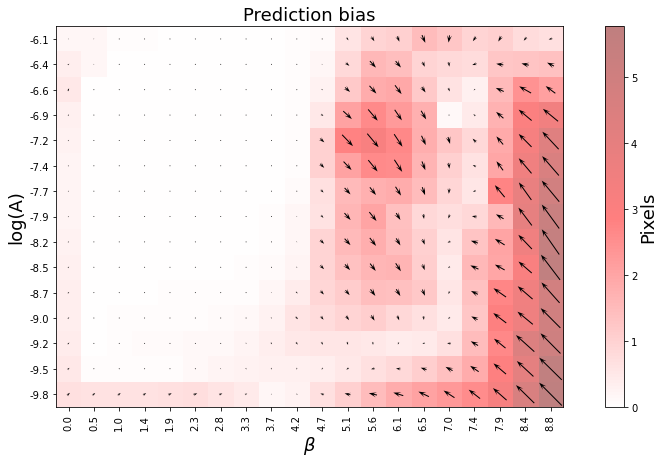

In [113]:
plt.figure(figsize=(15,7))
X,Y=np.meshgrid(Coarse_Beta_array,Coarse_logA_array)
I=predicted_bias[:,:,1]
J=predicted_bias[:,:,0]

img=plt.imshow(np.sqrt(I**2+J**2)/11,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0),alpha=0.5)
plt.quiver(I, J,scale=1000,width=0.002,headwidth=5,headlength=7.5,pivot='middle')



plt.gca().invert_yaxis()
plt.yticks(np.arange(len(Coarse_logA_array)),Coarse_logA_array.round(1))
plt.xticks(np.arange(len(Coarse_Beta_array)),Coarse_Beta_array.round(1),rotation=90)

plt.title('Prediction bias',fontsize=FS)
plt.ylabel('log(A)',fontsize=FS)
plt.xlabel(r'$\beta$',fontsize=FS)
cbar=plt.colorbar(img)
cbar.ax.set_ylabel('Pixels',rotation=90,fontsize=FS,labelpad=2)
plt.show()

## Constrained

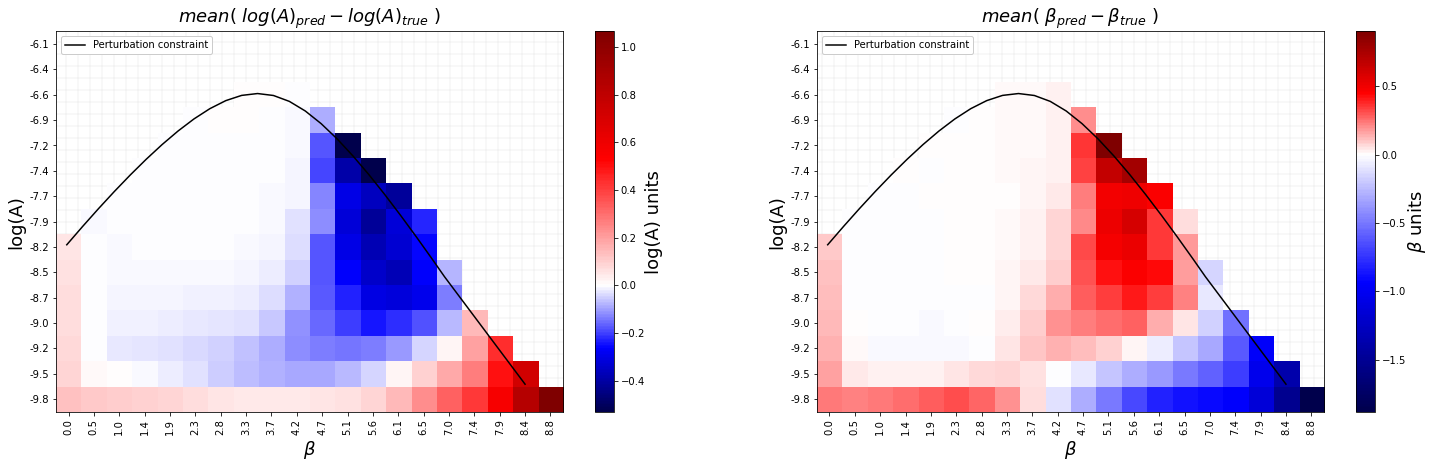

In [48]:
fig,ax=plt.subplots(1,2,figsize=(25,7))

img_arr=[]


img_arr+=[ax[0].imshow(Perturbation_matrix*predicted_bias[:,:,0]*(logA_array[1]-logA_array[0]),cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]
img_arr+=[ax[1].imshow(Perturbation_matrix*predicted_bias[:,:,1]*(Beta_array[1]-Beta_array[0]),cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]

titles=[r'$mean( \ log(A)_{pred}-log(A)_{true} \ )$',r'$mean( \ \beta_{pred}-\beta_{true} \ )$']
units=['log(A) units',r'$\beta$'+' units']

for i in range(2):
    
    #ax[i].patch.set_facecolor('k')
    ax[i].patch.set(hatch="+", edgecolor='black',alpha=0.05)
    
    ax[i].plot(Beta_threshold_indices,logA_threshold_indices,color='k',label='Perturbation constraint')
    ax[i].legend(loc='upper left', framealpha=1)
    
    ax[i].invert_yaxis()
    ax[i].set_yticks(np.arange(len(Coarse_logA_array)))
    ax[i].set_yticklabels(Coarse_logA_array.round(1))
    
    ax[i].set_xticks(np.arange(len(Coarse_Beta_array)))
    ax[i].set_xticklabels(Coarse_Beta_array.round(1),rotation=90)
    
    ax[i].set_ylabel('log(A)',fontsize=FS)
    ax[i].set_xlabel(r'$\beta$',fontsize=FS)
    ax[i].set_title(titles[i],fontsize=FS)
    
    cbar=plt.colorbar(img_arr[i],ax=ax[i])
    cbar.ax.set_ylabel(units[i],rotation=90,fontsize=FS,labelpad=0)

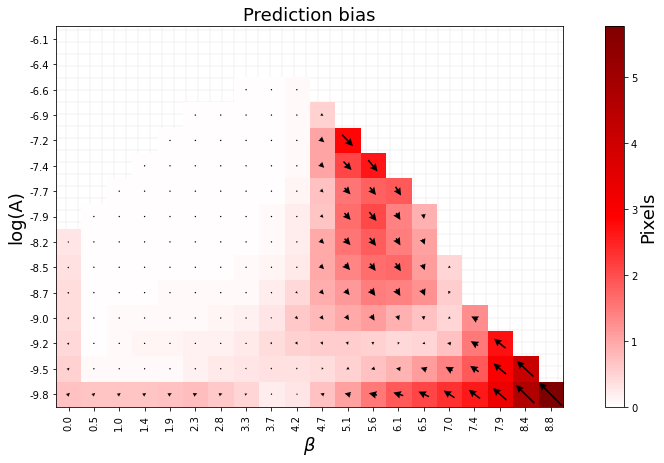

In [423]:
plt.figure(figsize=(15,7))
X,Y=np.meshgrid(Coarse_Beta_array,Coarse_logA_array)
I=predicted_bias[:,:,1]*Perturbation_matrix
J=predicted_bias[:,:,0]*Perturbation_matrix

img=plt.imshow(np.sqrt(I**2+J**2)/11,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0),alpha=1)
plt.quiver(I, J,scale=1000,width=0.003,headwidth=5,headlength=5,pivot='middle')

plt.gca().patch.set(hatch="+", edgecolor='black',alpha=0.05)


plt.gca().invert_yaxis()
plt.yticks(np.arange(len(Coarse_logA_array)),Coarse_logA_array.round(1))
plt.xticks(np.arange(len(Coarse_Beta_array)),Coarse_Beta_array.round(1),rotation=90)

plt.title('Prediction bias',fontsize=FS)
plt.ylabel('log(A)',fontsize=FS)
plt.xlabel(r'$\beta$',fontsize=FS)
cbar=plt.colorbar(img)
cbar.ax.set_ylabel('Pixels',rotation=90,fontsize=FS,labelpad=2)
plt.show()

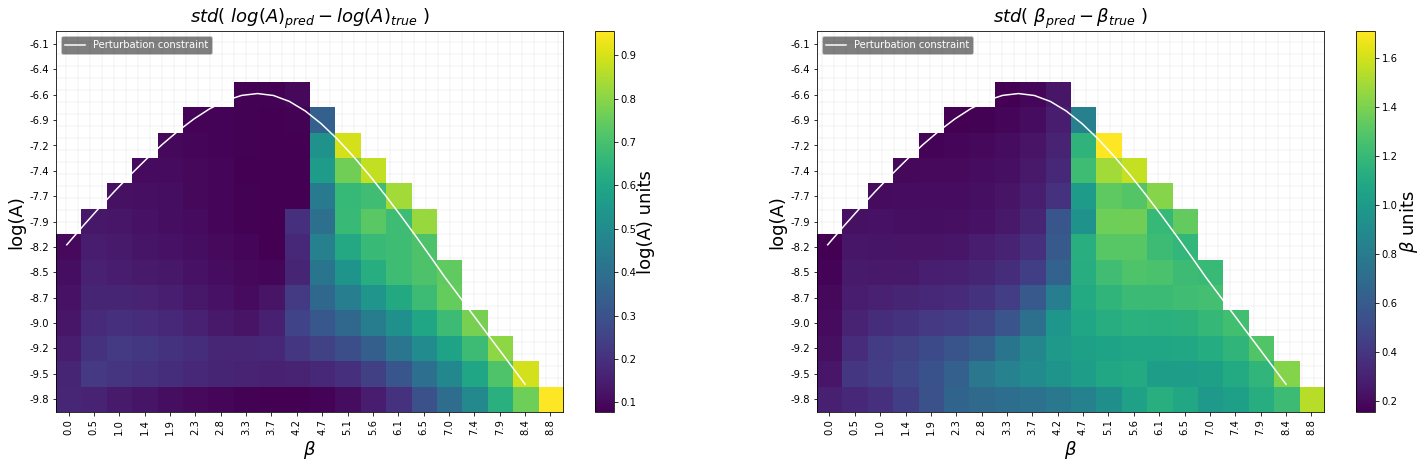

In [66]:
fig,ax=plt.subplots(1,2,figsize=(25,7))

img_arr=[]



img_arr+=[ax[0].imshow(Perturbation_matrix*predicted_bias_std[:,:,0]*(logA_array[1]-logA_array[0]))]
img_arr+=[ax[1].imshow(Perturbation_matrix*predicted_bias_std[:,:,1]*(Beta_array[1]-Beta_array[0]))]

titles=[r'$std( \ log(A)_{pred}-log(A)_{true} \ )$',r'$std( \ \beta_{pred}-\beta_{true} \ )$']
units=['log(A) units',r'$\beta$'+' units']

for i in range(2):
    
    
    ax[i].patch.set(hatch="+", edgecolor='black',alpha=0.05)
    
    ax[i].plot(Beta_threshold_indices,logA_threshold_indices,color='w',label='Perturbation constraint')
    l=ax[i].legend(loc='upper left',framealpha=0.5,facecolor='k')
    l.get_texts()[0].set_color('w')
    
    ax[i].invert_yaxis()
    ax[i].set_yticks(np.arange(len(Coarse_logA_array)))
    ax[i].set_yticklabels(Coarse_logA_array.round(1))
    
    ax[i].set_xticks(np.arange(len(Coarse_Beta_array)))
    ax[i].set_xticklabels(Coarse_Beta_array.round(1),rotation=90)
    
    ax[i].set_ylabel('log(A)',fontsize=FS)
    ax[i].set_xlabel(r'$\beta$',fontsize=FS)
    ax[i].set_title(titles[i],fontsize=FS)
    
    cbar=plt.colorbar(img_arr[i],ax=ax[i])
    cbar.ax.set_ylabel(units[i],rotation=90,fontsize=FS,labelpad=0)

In [407]:
deg_logA=[-9.2,-9.2,-9.,-8.5]
deg_Beta=[5.6,6.5,7,7]

In [410]:
data_images=np.zeros((len(deg_logA),100,100))

for i in range(len(deg_Beta)):
    GRF_params=[deg_logA[i],deg_Beta[i]]
    _,data_image,fit_image,_=generate_data(GRF_params,1,Observation_conditions,fit=False)
    data_images[i]=data_image

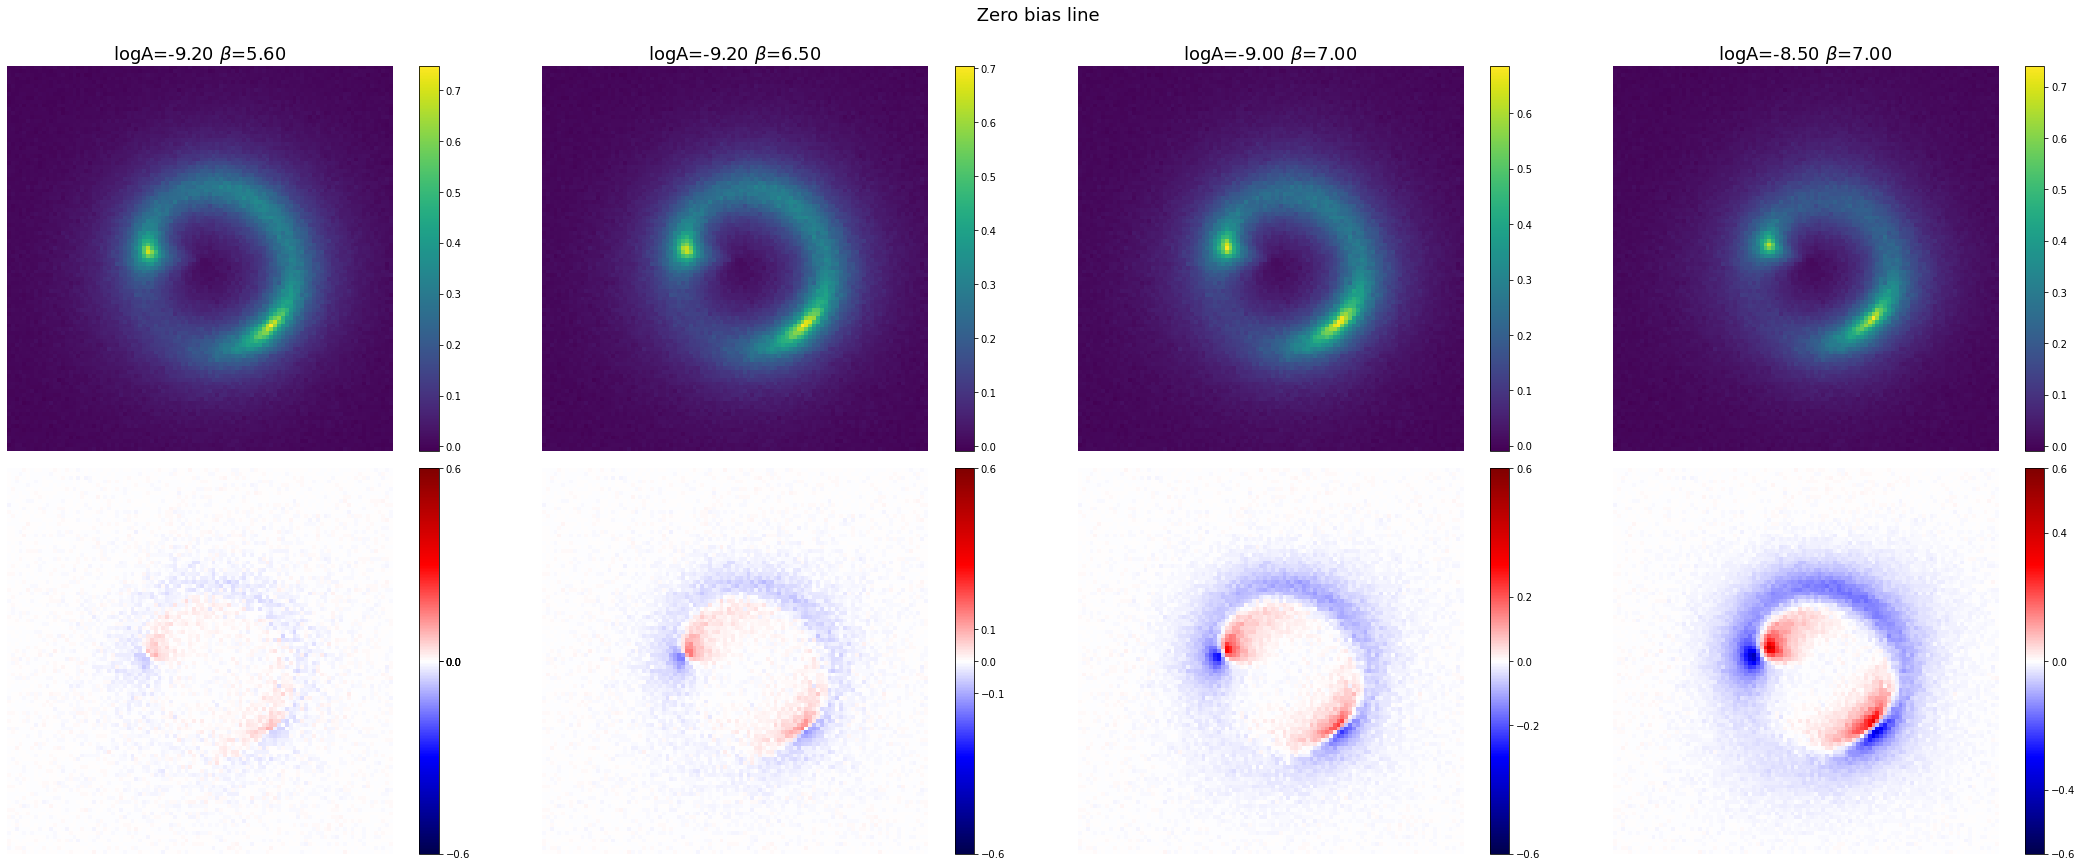

In [413]:
fig,ax=plt.subplots(2,len(deg_logA),figsize=(30,12))

images=np.array([data_images,data_images-Image_unperturbed_noiseless])

for i in range(2):
    axis_row=ax[i]
    img_arr=[]
    for j in range(len(deg_Beta)):
        axis=axis_row[j]
        image=images[i,j]
        
        if i==0:
            img=axis.imshow(image)
            fig.colorbar(img,ax=axis)
            axis.set_title('logA={:.2f} '.format(deg_logA[j])+r'$\beta$'+'={:.2f}'.format(deg_Beta[j]),fontsize=FS)
        else:
            img=axis.imshow(image,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0,-0.6,0.6))
            #img=axis.imshow(image,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0,images[:,1].min(),images[:,1].max()))
            colorborders=[-0.6,math.ceil(image.min()*1e+1)/1e+1,0,math.floor(image.max()*1e+1)/1e+1,0.6]
    
            #cbar=fig.colorbar(img,ax=axis,fraction=0.045)
            #cbar=fig.colorbar(img,ax=axis,ticks=[-0.7,0,0.7],fraction=0.045)
            cbar=fig.colorbar(img,ax=axis,ticks=colorborders)
            #cbar.ax.set_ylabel('Flux',rotation=90,fontsize=12,labelpad=0)
            #cbar.ax.set_yticklabels(['{:.1f}'.format(colorborders[0])+r'$\sigma$', '0', '{:.1f}'.format(colorborders[2])+r'$\sigma$'])
    
        axis.axis('off')
        
plt.suptitle(' Zero bias line',fontsize=FS,y=1.)
plt.tight_layout()
plt.show()

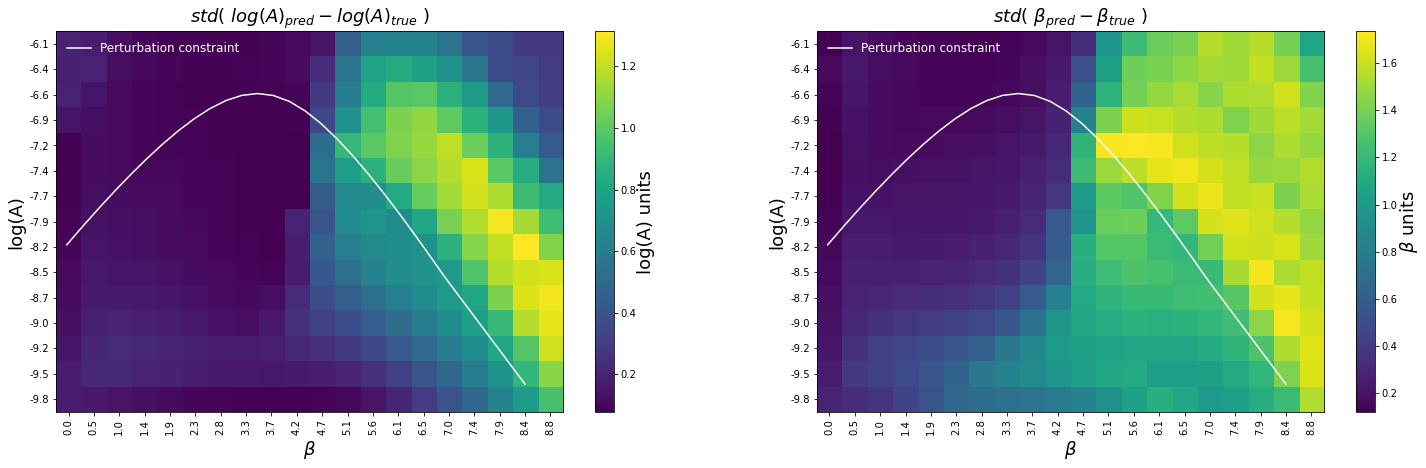

In [45]:
fig,ax=plt.subplots(1,2,figsize=(25,7))

img_arr=[]



img_arr+=[ax[0].imshow(predicted_bias_std[:,:,0]*(logA_array[1]-logA_array[0]))]
img_arr+=[ax[1].imshow(predicted_bias_std[:,:,1]*(Beta_array[1]-Beta_array[0]))]

titles=[r'$std( \ log(A)_{pred}-log(A)_{true} \ )$',r'$std( \ \beta_{pred}-\beta_{true} \ )$']
units=['log(A) units',r'$\beta$'+' units']

for i in range(2):
    
    ax[i].plot(Beta_threshold_indices,logA_threshold_indices,color='w',label='Perturbation constraint')
    
    #imgSNR=ax[i].contour(np.arange(0,len(Beta_array))/11,np.arange(0,len(logA_array))/11,SNR_grid,[0],colors='w',linestyles='--')
    #imgSNR.collections[0].set_label('SNR=0')
    l=ax[i].legend(loc='upper left',framealpha=0,fontsize=12)
    l.get_texts()[0].set_color('w')
    #l.get_texts()[1].set_color('w')
    
    ax[i].invert_yaxis()
    ax[i].set_yticks(np.arange(len(Coarse_logA_array)))
    ax[i].set_yticklabels(Coarse_logA_array.round(1))
    
    ax[i].set_xticks(np.arange(len(Coarse_Beta_array)))
    ax[i].set_xticklabels(Coarse_Beta_array.round(1),rotation=90)
    
    ax[i].set_ylabel('log(A)',fontsize=FS)
    ax[i].set_xlabel(r'$\beta$',fontsize=FS)
    ax[i].set_title(titles[i],fontsize=FS)
    
    cbar=plt.colorbar(img_arr[i],ax=ax[i])
    cbar.ax.set_ylabel(units[i],rotation=90,fontsize=FS,labelpad=0)

In [41]:
generate_data??

In [42]:
_,data_image,_,_=generate_data([-7.9,7.9],1,Observation_conditions,False,False)

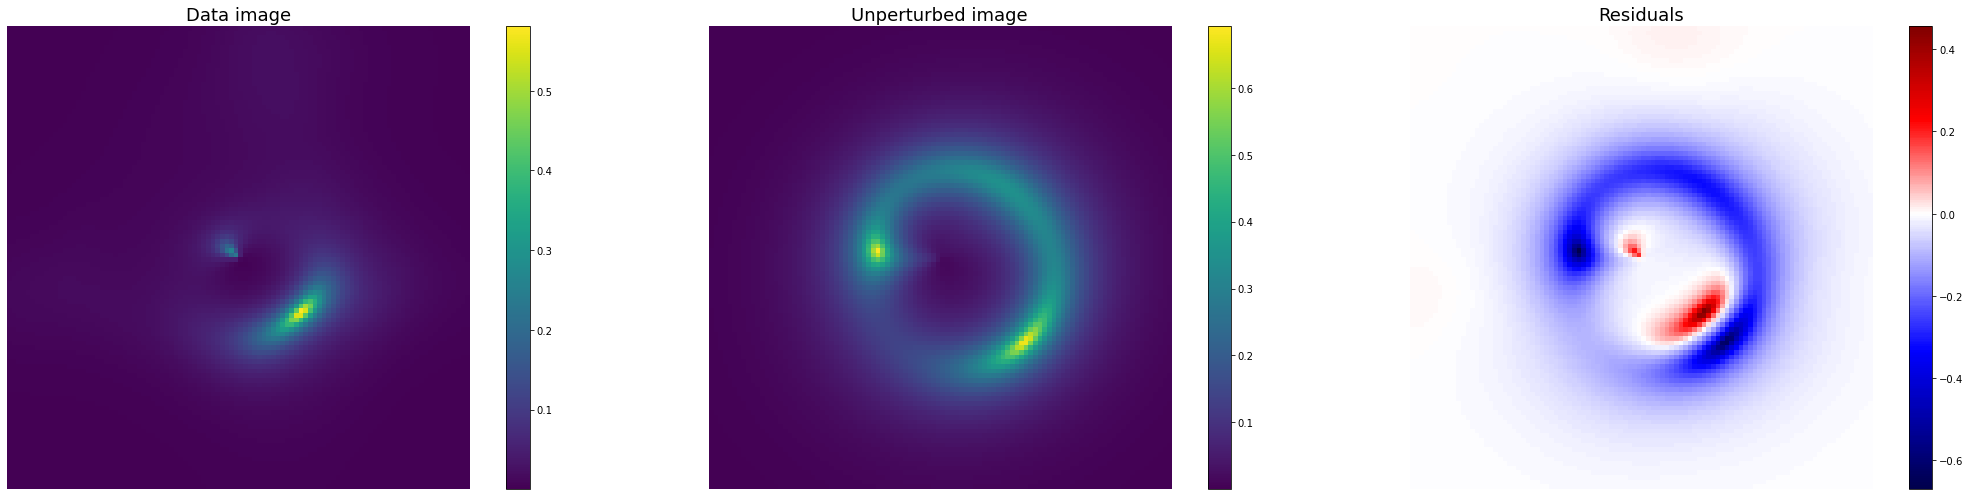

In [44]:
fig,ax=plt.subplots(1,3,figsize=(30,7))

img_arr=[]

img_arr+=[ax[0].imshow(data_image)]
img_arr+=[ax[1].imshow(Image_unperturbed_noiseless)]
img_arr+=[ax[2].imshow(data_image-Image_unperturbed_noiseless,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]

titles=['Data image','Unperturbed image','Residuals']

for i,axis in enumerate(ax):
    axis.set_title(titles[i],fontsize=FS)
    axis.axis('off')
    fig.colorbar(img_arr[i],ax=axis)

plt.tight_layout()
plt.show()

Text(0, 0.5, 'logA units')

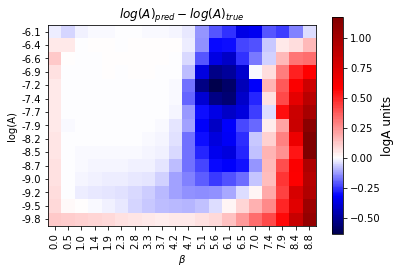

In [20]:
plt.imshow(predicted_bias[:,:,0]*(logA_array[1]-logA_array[0]),cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
plt.title(r'$log(A)_{pred}-log(A)_{true}$')


plt.gca().invert_yaxis()
plt.yticks(np.arange(len(Coarse_logA_array)),Coarse_logA_array.round(1))
plt.xticks(np.arange(len(Coarse_Beta_array)),Coarse_Beta_array.round(1),rotation=90)
plt.ylabel('log(A)')
plt.xlabel(r'$\beta$')
cbar=plt.colorbar()
cbar.ax.set_ylabel('logA units',rotation=90,fontsize=12,labelpad=0)

In [115]:
Loss_tensor.shape

(15, 20, 100, 160, 214)

Text(0, 0.5, 'Beta units')

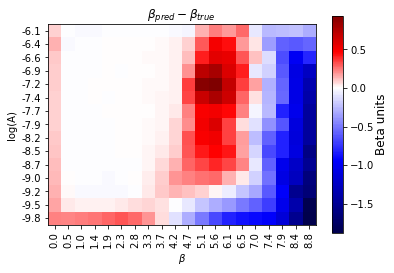

In [116]:
plt.imshow(predicted_bias[:,:,1]*(Beta_array[1]-Beta_array[0]),cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
plt.title(r'$\beta_{pred}-\beta_{true}$')


plt.gca().invert_yaxis()
plt.yticks(np.arange(len(Coarse_logA_array)),Coarse_logA_array.round(1))
plt.xticks(np.arange(len(Coarse_Beta_array)),Coarse_Beta_array.round(1),rotation=90)
plt.ylabel('log(A)')
plt.xlabel(r'$\beta$')
cbar=plt.colorbar()
cbar.ax.set_ylabel('Beta units',rotation=90,fontsize=12,labelpad=0)

# Region width

Central region is biased towards lower amplitude and higher scale.
Right region towards the opposite.

In [51]:
predicted_width_up=np.zeros((15,20,2))
predicted_width=np.zeros((15,20,2))
predicted_width_down=np.zeros((15,20,2))
for i in range(15):
    for j in range(20):
        
        region_indices=one_sigma_border_indices
        
        predicted_width_up[i,j,0]=np.nanmean(region_indices[i,j,:,1]-predicted_indices[i,j,:,0])
        predicted_width_down[i,j,0]= -np.nanmean(region_indices[i,j,:,0]-predicted_indices[i,j,:,0])
        
        
        predicted_width_up[i,j,1]=np.nanmean(region_indices[i,j,:,3]-predicted_indices[i,j,:,1])
        predicted_width_down[i,j,1]= -np.nanmean(region_indices[i,j,:,2]-predicted_indices[i,j,:,1])
        
        predicted_width[i,j,0]=np.nanmean(region_indices[i,j,:,1]-region_indices[i,j,:,0])
        predicted_width[i,j,1]=np.nanmean(region_indices[i,j,:,3]-region_indices[i,j,:,2])

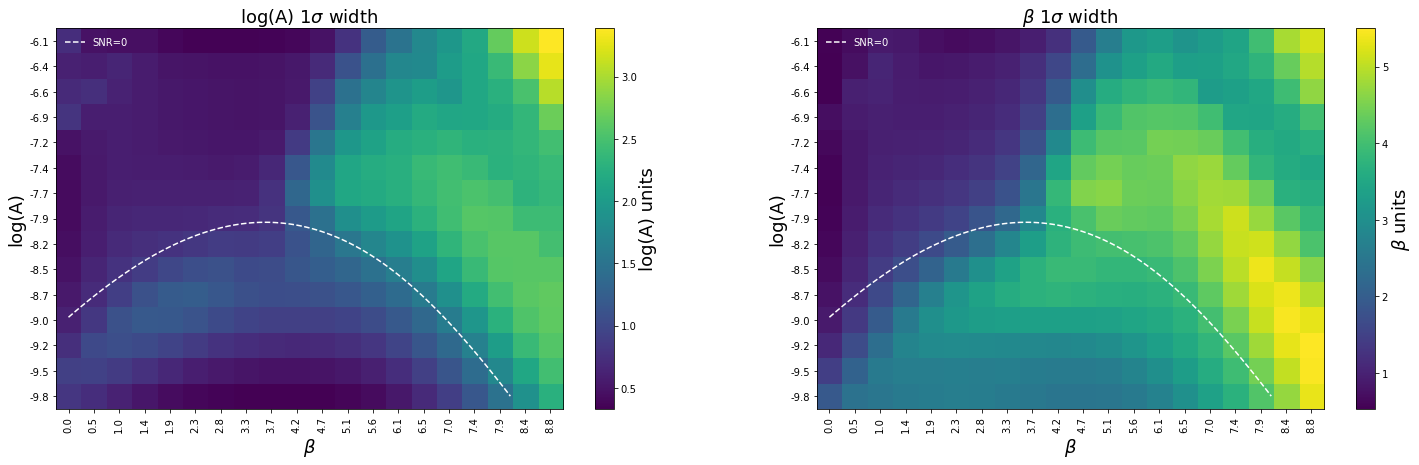

In [52]:
fig,ax=plt.subplots(1,2,figsize=(25,7))

img_arr=[]

img_arr+=[ax[0].imshow(predicted_width[:,:,0]*(logA_array[1]-logA_array[0]),cmap='viridis')]
img_arr+=[ax[1].imshow(predicted_width[:,:,1]*(Beta_array[1]-Beta_array[0]),cmap='viridis')]

titles=['log(A) '+r'$1\sigma$'+' width',r'$\beta \ 1\sigma$'+' width']
units=['log(A) units',r'$\beta$'+' units']

for i in range(2):
    
    imgSNR=ax[i].contour(np.arange(0,len(Beta_array))/11,np.arange(0,len(logA_array))/11,SNR_grid,[0],colors='w',linestyles='--')
    imgSNR.collections[0].set_label('SNR=0')
    l=ax[i].legend(loc='upper left',framealpha=0)
    l.get_texts()[0].set_color('w')
    
    
    ax[i].invert_yaxis()
    ax[i].set_yticks(np.arange(len(Coarse_logA_array)))
    ax[i].set_yticklabels(Coarse_logA_array.round(1))
    
    ax[i].set_xticks(np.arange(len(Coarse_Beta_array)))
    ax[i].set_xticklabels(Coarse_Beta_array.round(1),rotation=90)
    
    ax[i].set_ylabel('log(A)',fontsize=FS)
    ax[i].set_xlabel(r'$\beta$',fontsize=FS)
    ax[i].set_title(titles[i],fontsize=FS)
    
    cbar=plt.colorbar(img_arr[i],ax=ax[i])
    cbar.ax.set_ylabel(units[i],rotation=90,fontsize=FS,labelpad=2)

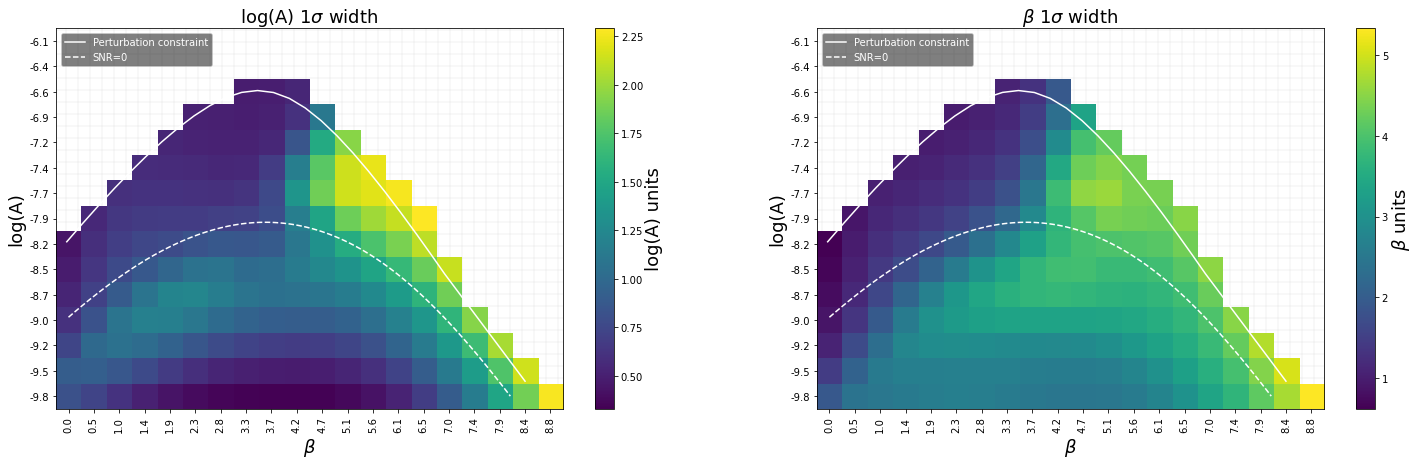

In [64]:
fig,ax=plt.subplots(1,2,figsize=(25,7))

img_arr=[]

img_arr+=[ax[0].imshow(Perturbation_matrix*predicted_width[:,:,0]*(logA_array[1]-logA_array[0]),cmap='viridis')]
img_arr+=[ax[1].imshow(Perturbation_matrix*predicted_width[:,:,1]*(Beta_array[1]-Beta_array[0]),cmap='viridis')]

titles=['log(A) '+r'$1\sigma$'+' width',r'$\beta \ 1\sigma$'+' width']
units=['log(A) units',r'$\beta$'+' units']

for i in range(2):
    
    
    ax[i].patch.set(hatch="+", edgecolor='black',alpha=0.05)
    
    ax[i].plot(Beta_threshold_indices,logA_threshold_indices,color='w',label='Perturbation constraint')
    
    
    imgSNR=ax[i].contour(np.arange(0,len(Beta_array))/11,np.arange(0,len(logA_array))/11,SNR_grid,[0],colors='w',linestyles='--')
    imgSNR.collections[0].set_label('SNR=0')
    l=ax[i].legend(loc='upper left',framealpha=0.5,facecolor='k')
    l.get_texts()[0].set_color('w')
    l.get_texts()[1].set_color('w')
    
    
    ax[i].invert_yaxis()
    ax[i].set_yticks(np.arange(len(Coarse_logA_array)))
    ax[i].set_yticklabels(Coarse_logA_array.round(1))
    
    ax[i].set_xticks(np.arange(len(Coarse_Beta_array)))
    ax[i].set_xticklabels(Coarse_Beta_array.round(1),rotation=90)
    
    ax[i].set_ylabel('log(A)',fontsize=FS)
    ax[i].set_xlabel(r'$\beta$',fontsize=FS)
    ax[i].set_title(titles[i],fontsize=FS)
    
    cbar=plt.colorbar(img_arr[i],ax=ax[i])
    cbar.ax.set_ylabel(units[i],rotation=90,fontsize=FS,labelpad=2)

In [124]:
predicted_width_up=np.zeros((15,20,2))
predicted_width=np.zeros((15,20,2))
predicted_width_down=np.zeros((15,20,2))
for i in range(15):
    for j in range(20):
        
        region_indices=two_sigma_border_indices
        
        predicted_width_up[i,j,0]=np.nanmean(region_indices[i,j,:,1]-predicted_indices[i,j,:,0])
        predicted_width_down[i,j,0]= -np.nanmean(region_indices[i,j,:,0]-predicted_indices[i,j,:,0])
        
        
        predicted_width_up[i,j,1]=np.nanmean(region_indices[i,j,:,3]-predicted_indices[i,j,:,1])
        predicted_width_down[i,j,1]= -np.nanmean(region_indices[i,j,:,2]-predicted_indices[i,j,:,1])
        
        predicted_width[i,j,0]=np.nanmean(region_indices[i,j,:,1]-region_indices[i,j,:,0])
        predicted_width[i,j,1]=np.nanmean(region_indices[i,j,:,3]-region_indices[i,j,:,2])

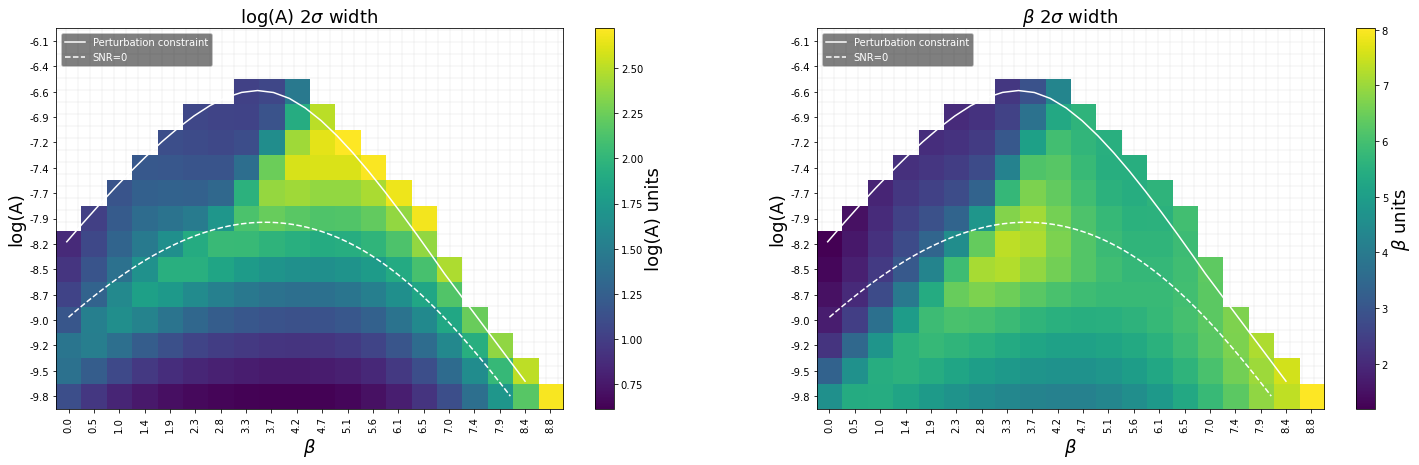

In [125]:
fig,ax=plt.subplots(1,2,figsize=(25,7))

img_arr=[]

img_arr+=[ax[0].imshow(Perturbation_matrix*predicted_width[:,:,0]*(logA_array[1]-logA_array[0]),cmap='viridis')]
img_arr+=[ax[1].imshow(Perturbation_matrix*predicted_width[:,:,1]*(Beta_array[1]-Beta_array[0]),cmap='viridis')]

titles=['log(A) '+r'$2\sigma$'+' width',r'$\beta \ 2\sigma$'+' width']
units=['log(A) units',r'$\beta$'+' units']

for i in range(2):
    
    
    ax[i].patch.set(hatch="+", edgecolor='black',alpha=0.05)
    
    ax[i].plot(Beta_threshold_indices,logA_threshold_indices,color='w',label='Perturbation constraint')
    
    
    imgSNR=ax[i].contour(np.arange(0,len(Beta_array))/11,np.arange(0,len(logA_array))/11,SNR_grid,[0],colors='w',linestyles='--')
    imgSNR.collections[0].set_label('SNR=0')
    l=ax[i].legend(loc='upper left',framealpha=0.5,facecolor='k')
    l.get_texts()[0].set_color('w')
    l.get_texts()[1].set_color('w')
    
    
    ax[i].invert_yaxis()
    ax[i].set_yticks(np.arange(len(Coarse_logA_array)))
    ax[i].set_yticklabels(Coarse_logA_array.round(1))
    
    ax[i].set_xticks(np.arange(len(Coarse_Beta_array)))
    ax[i].set_xticklabels(Coarse_Beta_array.round(1),rotation=90)
    
    ax[i].set_ylabel('log(A)',fontsize=FS)
    ax[i].set_xlabel(r'$\beta$',fontsize=FS)
    ax[i].set_title(titles[i],fontsize=FS)
    
    cbar=plt.colorbar(img_arr[i],ax=ax[i])
    cbar.ax.set_ylabel(units[i],rotation=90,fontsize=FS,labelpad=2)

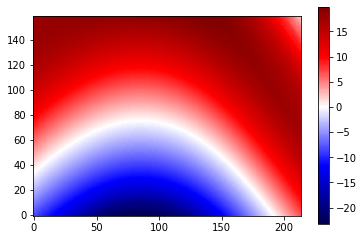

In [72]:
plt.imshow(SNR_grid,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
plt.gca().invert_yaxis()
plt.colorbar()

In [101]:
Noise_spectra=jax_map(compute_radial_spectrum_pure,np.array([np.random.normal(0,np.sqrt(noise_var)) for i in range(10000)]))

In [104]:
logMean_Spectra_grid=np.exp(np.log(Spectra_grid).mean(axis=-2))
logMean_Noise_grid=np.exp(np.log(Noise_spectra).mean(axis=-2))
logmean_SNR=np.nanmean(10*np.log10((logMean_Spectra_grid-logMean_Noise_grid)/logMean_Noise_grid),axis=-1)

/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_25457/3780760208.py:3: RuntimeWarning: invalid value encountered in log10
  logmean_SNR=np.nanmean(10*np.log10((logMean_Spectra_grid-logMean_Noise_grid)/logMean_Noise_grid),axis=-1)


In [119]:
logMean_Noise_grid

array([7.65438412e-05, 7.69416291e-05, 7.76037715e-05, 7.78810576e-05,
       7.79224383e-05, 7.83598471e-05, 7.85573290e-05, 7.86835348e-05,
       7.86632981e-05, 7.87937732e-05, 7.87191954e-05, 7.88418205e-05,
       7.90466576e-05, 7.90718755e-05, 7.90717071e-05, 7.92113326e-05,
       7.89601375e-05, 7.89043296e-05, 7.90130938e-05, 7.91527157e-05,
       7.91655723e-05, 7.93682505e-05, 7.93626433e-05, 7.93664475e-05,
       7.92721893e-05, 7.92592996e-05, 7.92269643e-05, 7.92564570e-05,
       7.93944576e-05, 7.92985073e-05, 7.92564189e-05, 7.92194965e-05,
       7.92649502e-05, 7.93499075e-05, 7.94241308e-05, 7.93762902e-05,
       7.94022387e-05, 7.93424421e-05, 7.94172027e-05, 7.93651685e-05,
       7.93786629e-05, 7.93010641e-05, 7.93577705e-05, 7.93959721e-05,
       7.93895734e-05, 7.93872266e-05])

In [123]:
Estimated_Noise_spectral_density

DeviceArray(7.97337678e-05, dtype=float64)

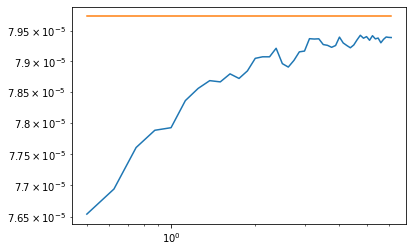

In [121]:
plt.loglog(Observation_conditions.frequencies,logMean_Noise_grid)
plt.loglog(Observation_conditions.frequencies,np.ones_like(Observation_conditions.frequencies)*Estimated_Noise_spectral_density)

(array([1.000e+00, 4.000e+00, 1.500e+01, 4.800e+01, 1.360e+02, 3.050e+02,
        5.200e+02, 8.650e+02, 1.192e+03, 1.409e+03, 1.537e+03, 1.435e+03,
        1.080e+03, 7.050e+02, 4.070e+02, 2.060e+02, 9.300e+01, 2.500e+01,
        1.400e+01, 3.000e+00]),
 array([-9.79436658, -9.76005403, -9.72574148, -9.69142892, -9.65711637,
        -9.62280382, -9.58849127, -9.55417872, -9.51986617, -9.48555361,
        -9.45124106, -9.41692851, -9.38261596, -9.34830341, -9.31399085,
        -9.2796783 , -9.24536575, -9.2110532 , -9.17674065, -9.1424281 ,
        -9.10811554]),
 <BarContainer object of 20 artists>)

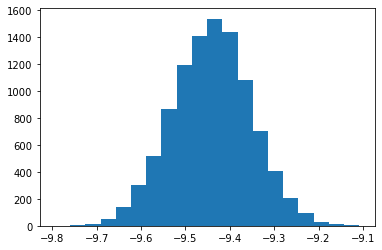

In [134]:
plt.hist(np.log(Noise_spectra[:,40]),bins=20)

(array([ 3.,  2.,  2.,  5.,  2.,  5.,  8.,  8., 14., 10.,  9.,  9., 11.,
         4.,  3.,  1.,  2.,  1.,  0.,  1.]),
 array([-9.4248145 , -9.41624866, -9.40768282, -9.39911697, -9.39055113,
        -9.38198528, -9.37341944, -9.3648536 , -9.35628775, -9.34772191,
        -9.33915607, -9.33059022, -9.32202438, -9.31345853, -9.30489269,
        -9.29632685, -9.287761  , -9.27919516, -9.27062932, -9.26206347,
        -9.25349763]),
 <BarContainer object of 20 artists>)

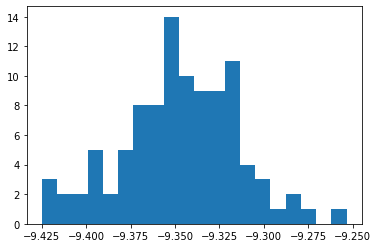

In [139]:
plt.hist(np.log(Spectra_grid[0,0,:,40]),bins=20)

In [107]:
(logMean_Spectra_grid-logMean_Noise_grid).shape

(160, 214, 46)

Text(0.5, 0, '$\\beta$')

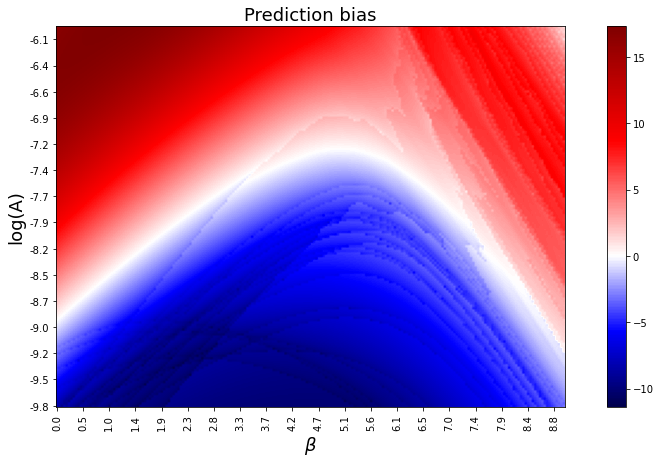

In [105]:
plt.figure(figsize=(15,7))
plt.imshow(logmean_SNR,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
plt.gca().invert_yaxis()
plt.colorbar()



plt.yticks(np.arange(0,len(logA_array),11),logA_array[::11].round(1))
plt.xticks(np.arange(0,len(Beta_array),11),Beta_array[::11].round(1),rotation=90)

plt.title('Prediction bias',fontsize=FS)
plt.ylabel('log(A)',fontsize=FS)
plt.xlabel(r'$\beta$',fontsize=FS)

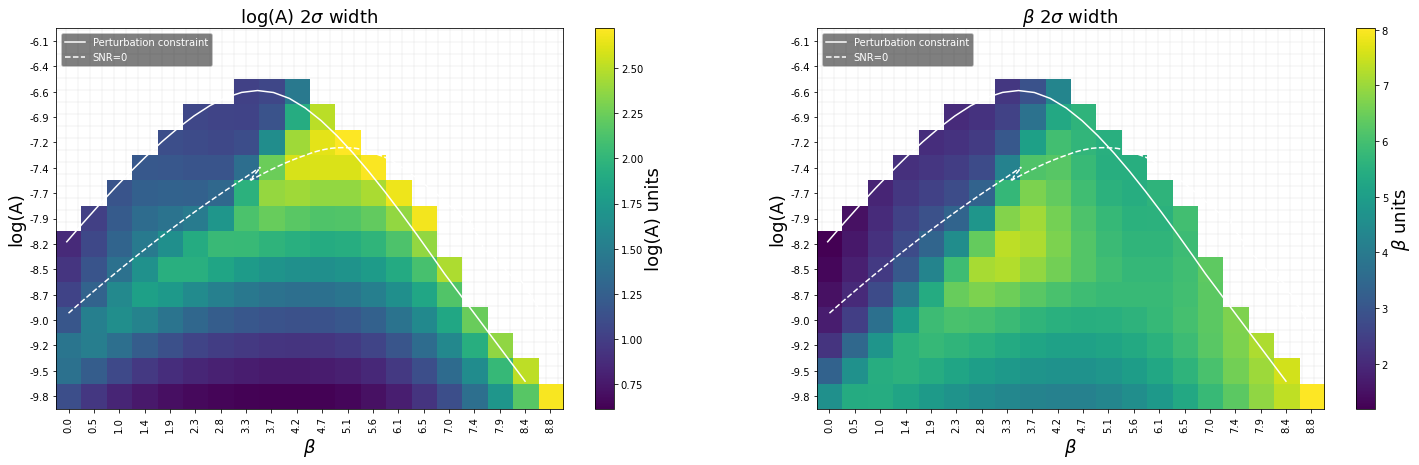

In [126]:
fig,ax=plt.subplots(1,2,figsize=(25,7))

img_arr=[]

img_arr+=[ax[0].imshow(Perturbation_matrix*predicted_width[:,:,0]*(logA_array[1]-logA_array[0]),cmap='viridis')]
img_arr+=[ax[1].imshow(Perturbation_matrix*predicted_width[:,:,1]*(Beta_array[1]-Beta_array[0]),cmap='viridis')]

titles=['log(A) '+r'$2\sigma$'+' width',r'$\beta \ 2\sigma$'+' width']
units=['log(A) units',r'$\beta$'+' units']

for i in range(2):
    
    
    ax[i].patch.set(hatch="+", edgecolor='black',alpha=0.05)
    
    ax[i].plot(Beta_threshold_indices,logA_threshold_indices,color='w',label='Perturbation constraint')
    
    
    imgSNR=ax[i].contour(np.arange(0,len(Beta_array))/11,np.arange(0,len(logA_array))/11,logmean_SNR,[0],colors='w',linestyles='--')
    imgSNR.collections[0].set_label('SNR=0')
    l=ax[i].legend(loc='upper left',framealpha=0.5,facecolor='k')
    l.get_texts()[0].set_color('w')
    l.get_texts()[1].set_color('w')
    
    
    ax[i].invert_yaxis()
    ax[i].set_yticks(np.arange(len(Coarse_logA_array)))
    ax[i].set_yticklabels(Coarse_logA_array.round(1))
    
    ax[i].set_xticks(np.arange(len(Coarse_Beta_array)))
    ax[i].set_xticklabels(Coarse_Beta_array.round(1),rotation=90)
    
    ax[i].set_ylabel('log(A)',fontsize=FS)
    ax[i].set_xlabel(r'$\beta$',fontsize=FS)
    ax[i].set_title(titles[i],fontsize=FS)
    
    cbar=plt.colorbar(img_arr[i],ax=ax[i])
    cbar.ax.set_ylabel(units[i],rotation=90,fontsize=FS,labelpad=2)

In [69]:
predicted_width_up=np.zeros((15,20,2))
predicted_width=np.zeros((15,20,2))
predicted_width_down=np.zeros((15,20,2))
for i in range(15):
    for j in range(20):
        
        region_indices=three_sigma_border_indices
        
        predicted_width_up[i,j,0]=np.nanmean(region_indices[i,j,:,1]-predicted_indices[i,j,:,0])
        predicted_width_down[i,j,0]= -np.nanmean(region_indices[i,j,:,0]-predicted_indices[i,j,:,0])
        
        
        predicted_width_up[i,j,1]=np.nanmean(region_indices[i,j,:,3]-predicted_indices[i,j,:,1])
        predicted_width_down[i,j,1]= -np.nanmean(region_indices[i,j,:,2]-predicted_indices[i,j,:,1])
        
        predicted_width[i,j,0]=np.nanmean(region_indices[i,j,:,1]-region_indices[i,j,:,0])
        predicted_width[i,j,1]=np.nanmean(region_indices[i,j,:,3]-region_indices[i,j,:,2])

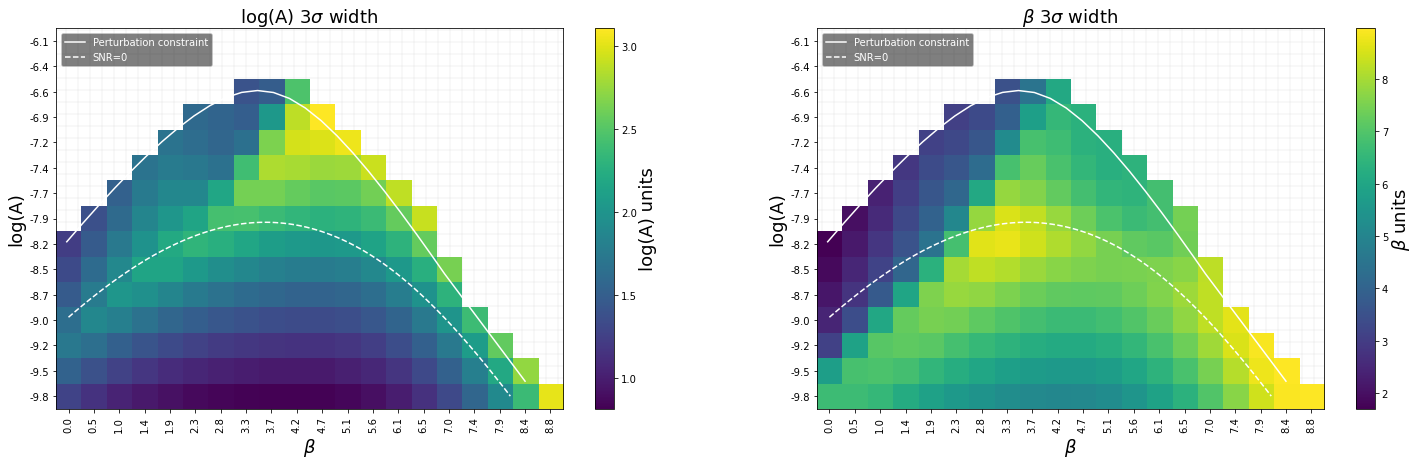

In [70]:
fig,ax=plt.subplots(1,2,figsize=(25,7))

img_arr=[]

img_arr+=[ax[0].imshow(Perturbation_matrix*predicted_width[:,:,0]*(logA_array[1]-logA_array[0]),cmap='viridis')]
img_arr+=[ax[1].imshow(Perturbation_matrix*predicted_width[:,:,1]*(Beta_array[1]-Beta_array[0]),cmap='viridis')]

titles=['log(A) '+r'$3\sigma$'+' width',r'$\beta \ 3\sigma$'+' width']
units=['log(A) units',r'$\beta$'+' units']

for i in range(2):
    
    ax[i].patch.set(hatch="+", edgecolor='black',alpha=0.05)
    
    ax[i].plot(Beta_threshold_indices,logA_threshold_indices,color='w',label='Perturbation constraint')
    
    
    imgSNR=ax[i].contour(np.arange(0,len(Beta_array))/11,np.arange(0,len(logA_array))/11,SNR_grid,[0],colors='w',linestyles='--')
    imgSNR.collections[0].set_label('SNR=0')
    l=ax[i].legend(loc='upper left',framealpha=0.5,facecolor='k')
    l.get_texts()[0].set_color('w')
    l.get_texts()[1].set_color('w')
    
    
    ax[i].invert_yaxis()
    ax[i].set_yticks(np.arange(len(Coarse_logA_array)))
    ax[i].set_yticklabels(Coarse_logA_array.round(1))
    
    ax[i].set_xticks(np.arange(len(Coarse_Beta_array)))
    ax[i].set_xticklabels(Coarse_Beta_array.round(1),rotation=90)
    
    ax[i].set_ylabel('log(A)',fontsize=FS)
    ax[i].set_xlabel(r'$\beta$',fontsize=FS)
    ax[i].set_title(titles[i],fontsize=FS)
    
    cbar=plt.colorbar(img_arr[i],ax=ax[i])
    cbar.ax.set_ylabel(units[i],rotation=90,fontsize=FS,labelpad=2)

# constrained

Central region is biased towards lower amplitude and higher scale.
Right region towards the opposite.

In [44]:
predicted_width_up=np.zeros((15,20,2))
predicted_width=np.zeros((15,20,2))
predicted_width_down=np.zeros((15,20,2))
for i in range(15):
    for j in range(20):
        
        region_indices=one_sigma_border_indices
        
        predicted_width_up[i,j,0]=np.nanmean(region_indices[i,j,:,1]-predicted_indices[i,j,:,0])
        predicted_width_down[i,j,0]= -np.nanmean(region_indices[i,j,:,0]-predicted_indices[i,j,:,0])
        
        
        predicted_width_up[i,j,1]=np.nanmean(region_indices[i,j,:,3]-predicted_indices[i,j,:,1])
        predicted_width_down[i,j,1]= -np.nanmean(region_indices[i,j,:,2]-predicted_indices[i,j,:,1])
        
        predicted_width[i,j,0]=np.nanmean(region_indices[i,j,:,1]-region_indices[i,j,:,0])
        predicted_width[i,j,1]=np.nanmean(region_indices[i,j,:,3]-region_indices[i,j,:,2])

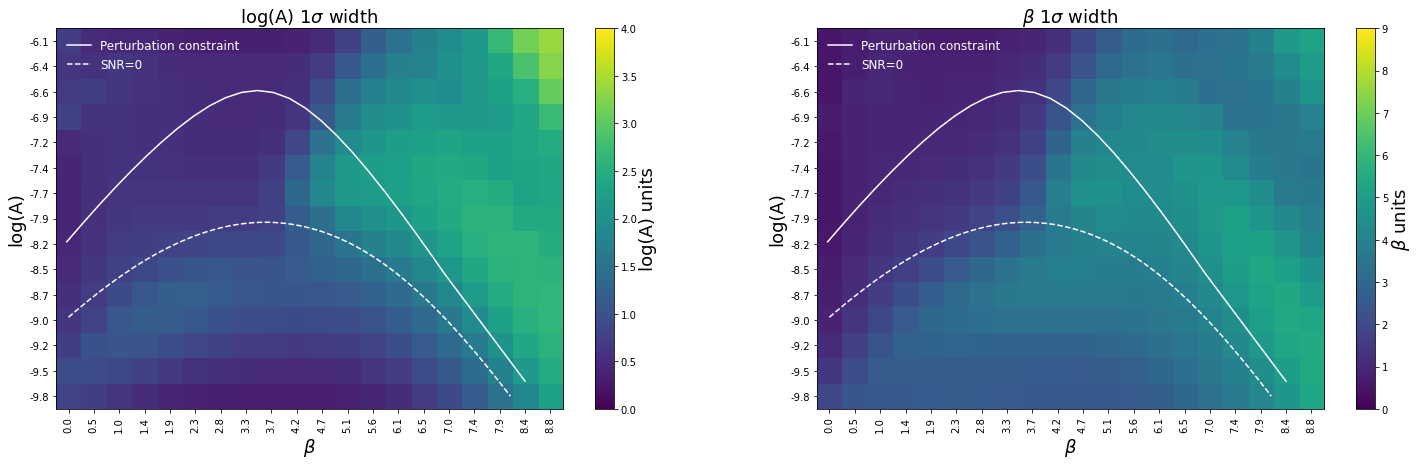

In [45]:
fig,ax=plt.subplots(1,2,figsize=(25,7))

img_arr=[]


img_arr+=[ax[0].imshow(predicted_width[:,:,0]*(logA_array[1]-logA_array[0]),cmap='viridis',vmin=0,vmax=4)]
img_arr+=[ax[1].imshow(predicted_width[:,:,1]*(Beta_array[1]-Beta_array[0]),cmap='viridis',vmin=0,vmax=9)]

titles=['log(A) '+r'$1\sigma$'+' width',r'$\beta \ 1\sigma$'+' width']
units=['log(A) units',r'$\beta$'+' units']

for i in range(2):
    
    ax[i].patch.set(hatch="+", edgecolor='black',alpha=0.05)
    
    ax[i].plot(Beta_threshold_indices,logA_threshold_indices,color='w',label='Perturbation constraint')
    
    imgSNR=ax[i].contour(np.arange(0,len(Beta_array))/11,np.arange(0,len(logA_array))/11,SNR_grid,[0],colors='w',linestyles='--')
    imgSNR.collections[0].set_label('SNR=0')
    l=ax[i].legend(loc='upper left',framealpha=0,fontsize=12)
    l.get_texts()[0].set_color('w')
    l.get_texts()[1].set_color('w')
    
    
    ax[i].invert_yaxis()
    ax[i].set_yticks(np.arange(len(Coarse_logA_array)))
    ax[i].set_yticklabels(Coarse_logA_array.round(1))
    
    ax[i].set_xticks(np.arange(len(Coarse_Beta_array)))
    ax[i].set_xticklabels(Coarse_Beta_array.round(1),rotation=90)
    
    ax[i].set_ylabel('log(A)',fontsize=FS)
    ax[i].set_xlabel(r'$\beta$',fontsize=FS)
    ax[i].set_title(titles[i],fontsize=FS)
    
    cbar=plt.colorbar(img_arr[i],ax=ax[i])
    cbar.ax.set_ylabel(units[i],rotation=90,fontsize=FS,labelpad=2)

In [46]:
predicted_width_up=np.zeros((15,20,2))
predicted_width=np.zeros((15,20,2))
predicted_width_down=np.zeros((15,20,2))
for i in range(15):
    for j in range(20):
        
        region_indices=two_sigma_border_indices
        
        predicted_width_up[i,j,0]=np.nanmean(region_indices[i,j,:,1]-predicted_indices[i,j,:,0])
        predicted_width_down[i,j,0]= -np.nanmean(region_indices[i,j,:,0]-predicted_indices[i,j,:,0])
        
        
        predicted_width_up[i,j,1]=np.nanmean(region_indices[i,j,:,3]-predicted_indices[i,j,:,1])
        predicted_width_down[i,j,1]= -np.nanmean(region_indices[i,j,:,2]-predicted_indices[i,j,:,1])
        
        predicted_width[i,j,0]=np.nanmean(region_indices[i,j,:,1]-region_indices[i,j,:,0])
        predicted_width[i,j,1]=np.nanmean(region_indices[i,j,:,3]-region_indices[i,j,:,2])

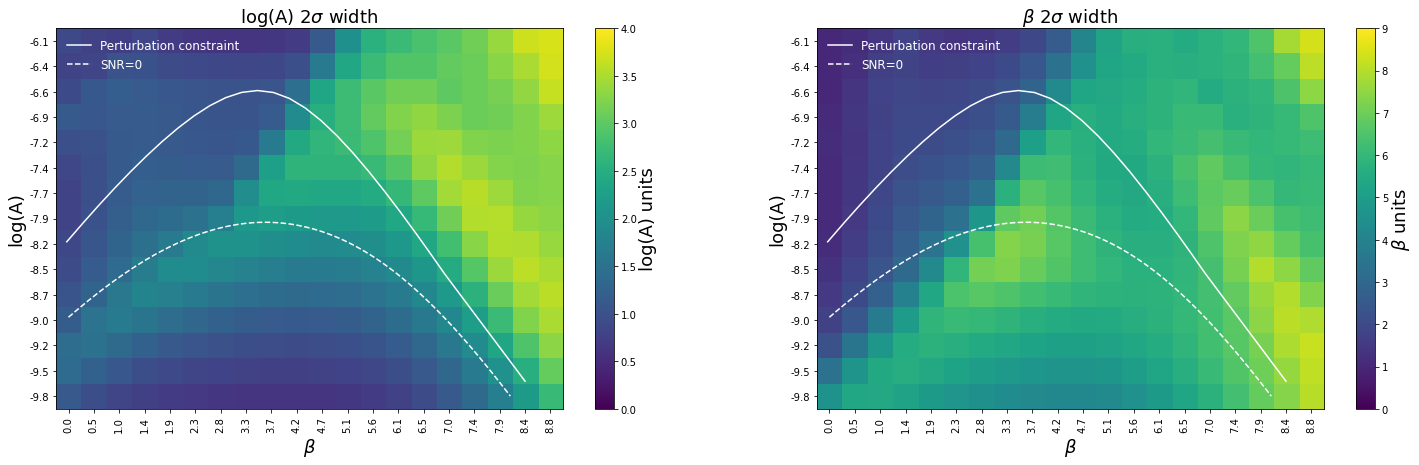

In [47]:
fig,ax=plt.subplots(1,2,figsize=(25,7))

img_arr=[]


img_arr+=[ax[0].imshow(predicted_width[:,:,0]*(logA_array[1]-logA_array[0]),cmap='viridis',vmin=0,vmax=4)]
img_arr+=[ax[1].imshow(predicted_width[:,:,1]*(Beta_array[1]-Beta_array[0]),cmap='viridis',vmin=0,vmax=9)]

titles=['log(A) '+r'$2\sigma$'+' width',r'$\beta \ 2\sigma$'+' width']
units=['log(A) units',r'$\beta$'+' units']

for i in range(2):
    
    ax[i].patch.set(hatch="+", edgecolor='black',alpha=0.05)
    
    ax[i].plot(Beta_threshold_indices,logA_threshold_indices,color='w',label='Perturbation constraint')
    
    imgSNR=ax[i].contour(np.arange(0,len(Beta_array))/11,np.arange(0,len(logA_array))/11,SNR_grid,[0],colors='w',linestyles='--')
    imgSNR.collections[0].set_label('SNR=0')
    l=ax[i].legend(loc='upper left',framealpha=0,fontsize=12)
    l.get_texts()[0].set_color('w')
    l.get_texts()[1].set_color('w')
    
    
    ax[i].invert_yaxis()
    ax[i].set_yticks(np.arange(len(Coarse_logA_array)))
    ax[i].set_yticklabels(Coarse_logA_array.round(1))
    
    ax[i].set_xticks(np.arange(len(Coarse_Beta_array)))
    ax[i].set_xticklabels(Coarse_Beta_array.round(1),rotation=90)
    
    ax[i].set_ylabel('log(A)',fontsize=FS)
    ax[i].set_xlabel(r'$\beta$',fontsize=FS)
    ax[i].set_title(titles[i],fontsize=FS)
    
    cbar=plt.colorbar(img_arr[i],ax=ax[i])
    cbar.ax.set_ylabel(units[i],rotation=90,fontsize=FS,labelpad=2)

In [48]:
predicted_width_up=np.zeros((15,20,2))
predicted_width=np.zeros((15,20,2))
predicted_width_down=np.zeros((15,20,2))
for i in range(15):
    for j in range(20):
        
        region_indices=three_sigma_border_indices
        
        predicted_width_up[i,j,0]=np.nanmean(region_indices[i,j,:,1]-predicted_indices[i,j,:,0])
        predicted_width_down[i,j,0]= -np.nanmean(region_indices[i,j,:,0]-predicted_indices[i,j,:,0])
        
        
        predicted_width_up[i,j,1]=np.nanmean(region_indices[i,j,:,3]-predicted_indices[i,j,:,1])
        predicted_width_down[i,j,1]= -np.nanmean(region_indices[i,j,:,2]-predicted_indices[i,j,:,1])
        
        predicted_width[i,j,0]=np.nanmean(region_indices[i,j,:,1]-region_indices[i,j,:,0])
        predicted_width[i,j,1]=np.nanmean(region_indices[i,j,:,3]-region_indices[i,j,:,2])

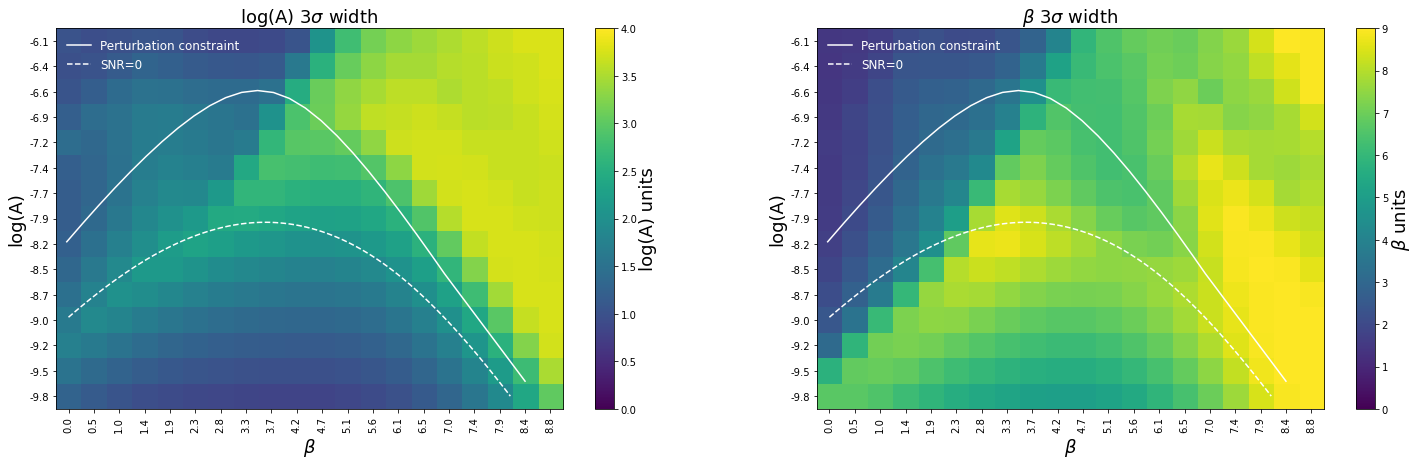

In [49]:
fig,ax=plt.subplots(1,2,figsize=(25,7))

img_arr=[]


img_arr+=[ax[0].imshow(predicted_width[:,:,0]*(logA_array[1]-logA_array[0]),cmap='viridis',vmin=0,vmax=4)]
img_arr+=[ax[1].imshow(predicted_width[:,:,1]*(Beta_array[1]-Beta_array[0]),cmap='viridis',vmin=0,vmax=9)]

titles=['log(A) '+r'$3\sigma$'+' width',r'$\beta \ 3\sigma$'+' width']
units=['log(A) units',r'$\beta$'+' units']

for i in range(2):
    
    ax[i].patch.set(hatch="+", edgecolor='black',alpha=0.05)
    
    ax[i].plot(Beta_threshold_indices,logA_threshold_indices,color='w',label='Perturbation constraint')
    
    imgSNR=ax[i].contour(np.arange(0,len(Beta_array))/11,np.arange(0,len(logA_array))/11,SNR_grid,[0],colors='w',linestyles='--')
    imgSNR.collections[0].set_label('SNR=0')
    l=ax[i].legend(loc='upper left',framealpha=0,fontsize=12)
    l.get_texts()[0].set_color('w')
    l.get_texts()[1].set_color('w')
    
    ax[i].invert_yaxis()
    ax[i].set_yticks(np.arange(len(Coarse_logA_array)))
    ax[i].set_yticklabels(Coarse_logA_array.round(1))
    
    ax[i].set_xticks(np.arange(len(Coarse_Beta_array)))
    ax[i].set_xticklabels(Coarse_Beta_array.round(1),rotation=90)
    
    ax[i].set_ylabel('log(A)',fontsize=FS)
    ax[i].set_xlabel(r'$\beta$',fontsize=FS)
    ax[i].set_title(titles[i],fontsize=FS)
    
    cbar=plt.colorbar(img_arr[i],ax=ax[i])
    cbar.ax.set_ylabel(units[i],rotation=90,fontsize=FS,labelpad=2)

In [39]:
(predicted_width[:,:,1]*(Beta_array[1]-Beta_array[0])).max()

8.968421052631559

In [38]:
(predicted_width[:,:,0]*(logA_array[1]-logA_array[0])).max()

3.7657894736842046